In [2]:
import pandas as pd
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import json
#uploaded = files.upload()
#import io 
#df= pd.read_csv(io.BytesIO(uploaded['Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv']))
#df= pd.read_csv('ZeroBias_2017UL_DataFrame_ChargeInnerLayer4.txt')
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/ZeroBias_2017UL_DataFrame_NormalizedHitResiduals_TIB__Layer__1.txt')
df['histo']=df['histo'].apply(literal_eval)

df.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df.sort_index(inplace=True)

print(df.tail())
print(df.shape)
print(df['histo'].shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
                  Unnamed: 0  ...                                              histo
fromrun fromlumi              ...                                                   
306462  95            211180  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        96            211181  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        97            211182  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        98            211183  ...  [0, 

In [3]:
#add Golden JSON labels to the DF
import json

def checkLS(run,ls):
    isok=False
    global jsondata
    
    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok=True
                return isok
        return isok

#load the golden json file
jsondata={}
with open('/content/drive/My Drive/Colab Notebooks/GoldenJSON17.json') as json_file:
    jsondata = json.load(json_file)

df['labels']=False #initialize to false

for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:
        df['labels'][run][ls]=checkLS(run,ls)

fname_bad = '/content/drive/My Drive/Colab Notebooks/BAD_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.txt'
fname_gold = '/content/drive/My Drive/Colab Notebooks/GOLDEN_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.txt'
df[df['labels']!=True].to_csv(fname_bad)
df[df['labels']==True].to_csv(fname_gold)

print(df[df['labels']!=True]) #to check against the Golden JSON
print(df.shape)



                  Unnamed: 0  ...  labels
fromrun fromlumi              ...        
297047  1              19614  ...   False
        2              19615  ...   False
        3              19616  ...   False
        4              19617  ...   False
        5              19618  ...   False
        6              19619  ...   False
        7              19620  ...   False
        8              19621  ...   False
        9              19622  ...   False
        10             19623  ...   False
        11             25243  ...   False
        12             25244  ...   False
        13             25245  ...   False
        14             25246  ...   False
        15             25247  ...   False
        16             25248  ...   False
        17             25249  ...   False
        18             25250  ...   False
        19             25172  ...   False
        20             25173  ...   False
        21             25174  ...   False
        22             25175  ... 

In [4]:
#extract test and train data and put in dataframes

#df_train=df.loc[df['labels']==True]
#df_test=df.loc[df['labels']==False]

X_trainS = np.stack(df['histo'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_testS = np.stack(df['histo'][df['labels']==False].values, axis=0)
print(X_trainS)

from sklearn.preprocessing import normalize

X_train=normalize(X_trainS, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test=normalize(X_testS, norm='l1', axis=1)
print(X_train)
                      
df['origin']=''
df['origin'].loc[df['labels']==True]=X_train.tolist()
df['origin'].loc[df['labels']==False]=X_test.tolist()
print(df.shape)
print(df.origin.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(225954, 12)
(225954,)


In [5]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
from keras.layers.advanced_activations import PReLU, ReLU
from keras.models import Model
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

input_size=len(X_train[0])
print(input_size)
input_layer = Input(shape=(input_size, ))
encoded = Dense(10, activation='relu')(input_layer)
encoded1 = Dense(3, activation='relu')(encoded)
encoded2 = Dense(10, activation='relu')(encoded1)
decoder = Dense(input_size, activation='tanh')(encoded2)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder.layers):
             layer.name = 'layer_' + str(i)

autoencoder.summary()

Using TensorFlow backend.


102
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (InputLayer)         (None, 102)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 10)                1030      
_________________________________________________________________
layer_2 (Dense)              (None, 3)                 33        
_________________________________________________________________
layer_3 (Dense)              (None, 10)                40        
_________________________________________________________________
layer_4 (Dense)              (None, 102)               1122      
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = autoencoder.fit(X_train,X_train, epochs=100, batch_size=500, shuffle=False, verbose=1,validation_split=0.1)

Train on 182069 samples, validate on 20230 samples
Epoch 1/100
182069/182069 [==============================] - 2s 10us/step - loss: 7.4178e-05 - val_loss: 1.3321e-06
Epoch 2/100
182069/182069 [==============================] - 2s 8us/step - loss: 1.1369e-06 - val_loss: 1.3515e-06
Epoch 3/100
182069/182069 [==============================] - 2s 8us/step - loss: 1.1177e-06 - val_loss: 1.3374e-06
Epoch 4/100
182069/182069 [==============================] - 2s 9us/step - loss: 1.1093e-06 - val_loss: 1.3008e-06
Epoch 5/100
182069/182069 [==============================] - 2s 8us/step - loss: 1.0971e-06 - val_loss: 1.2797e-06
Epoch 6/100
182069/182069 [==============================] - 2s 9us/step - loss: 1.0514e-06 - val_loss: 1.2916e-06
Epoch 7/100
182069/182069 [==============================] - 3s 15us/step - loss: 9.9040e-07 - val_loss: 1.2497e-06
Epoch 8/100
182069/182069 [==============================] - 3s 16us/step - loss: 9.5751e-07 - val_loss: 1.4649e-06
Epoch 9/100
182069/182069 

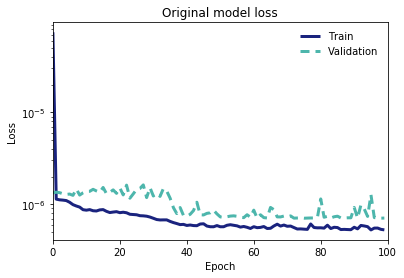

In [7]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history['loss'], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history['val_loss'], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    #plt.ylim(8258339,8258400)
    plt.yscale("log")
    plt.xlim(0,100)
    plt.show();

plot_loss(history, "Original model loss")

In [8]:
predictionTest=autoencoder.predict(X_test)
predictionTrain=autoencoder.predict(X_train)

mseTest=K.eval(mseTop10(X_test, predictionTest))
mseTrain=K.eval(mseTop10(X_train, predictionTrain))

df['prediction']=""
df['mse']=""

df['prediction'].loc[df['labels']==True]=predictionTrain.tolist()
df['prediction'].loc[df['labels']==False]=predictionTest.tolist()

df['mse'].loc[df['labels']==True]=mseTrain
df['mse'].loc[df['labels']==False]=mseTest

print(df.head())
#print(df_test.head())


                  Unnamed: 0  ...          mse
fromrun fromlumi              ...             
297047  1              19614  ...  4.36721e-07
        2              19615  ...  2.50782e-07
        3              19616  ...  3.63164e-07
        4              19617  ...  3.54829e-07
        5              19618  ...  4.26125e-07

[5 rows x 14 columns]


In [0]:
def globalMSETrend(df,type=1):
    
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in df['fromrun'].unique():
        if (type==1): val=(df['mse'][run]).mean()
        if (type==2): val=(df['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="blue", label="Run average: " + str(gmean))
    plt.hlines(gmean+(1.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='1 SD (' + str(gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.ylim(rmin*0.9,rmax*1.1)
    plt.scatter(df['fromrun'].unique(), y, marker='+', label='Data points')
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend()
    plt.show()

(0, 10)
469.0


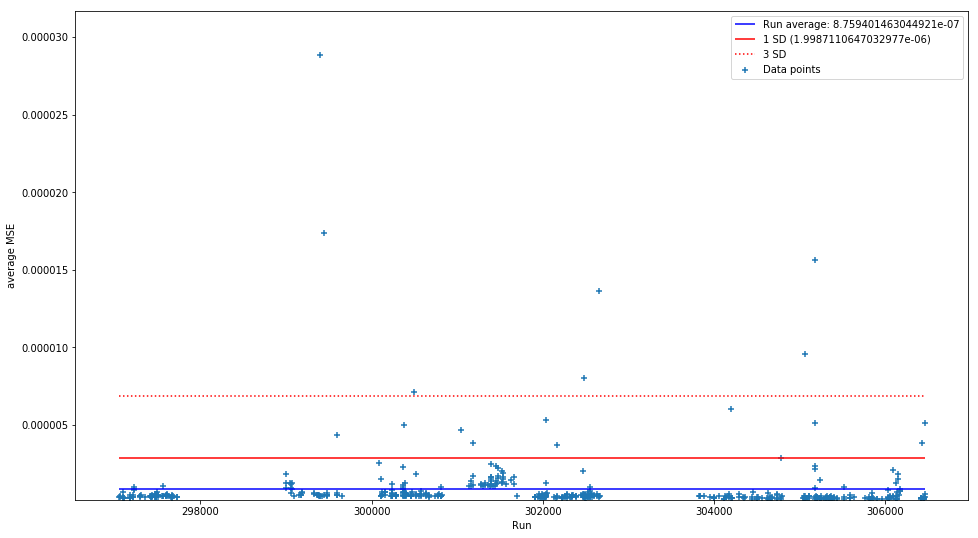

In [10]:
globalMSETrend(df[df.labels==True])

In [0]:
def CheckPredictions(df_test, run, ls):

    Xmax= 5.0
    Xmin=-5.0
    Xbins=102
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    mse=df_test['mse'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Reco MSE=" + str(mse))
    plt.xlabel("Hit Residuals TIB L1")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

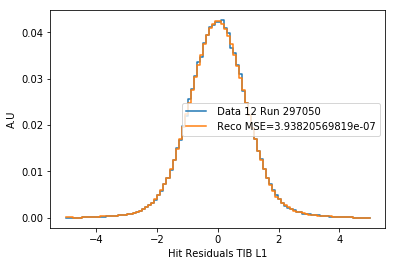

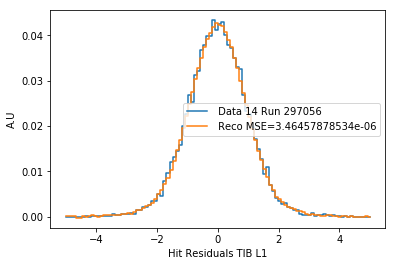

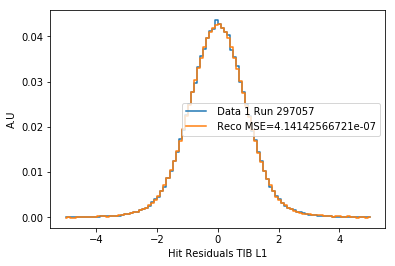

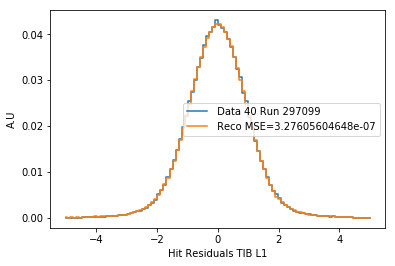

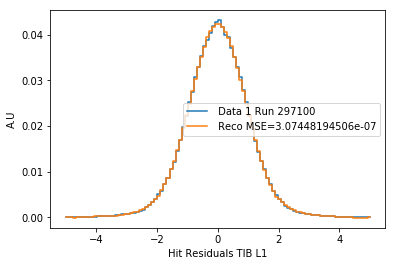

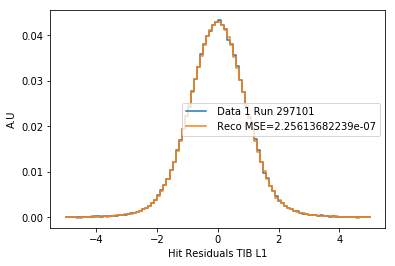

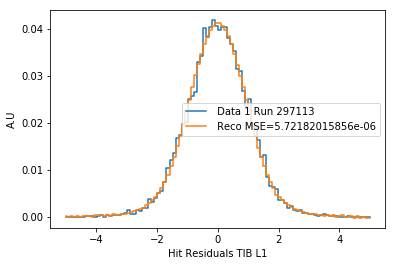

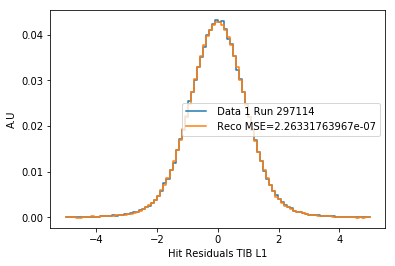

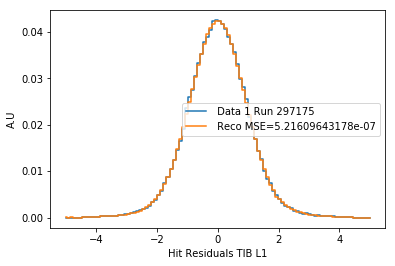

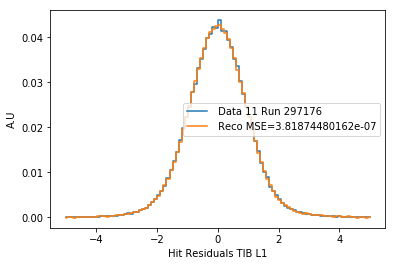

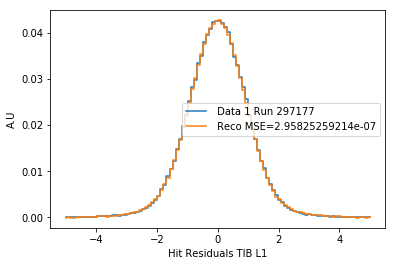

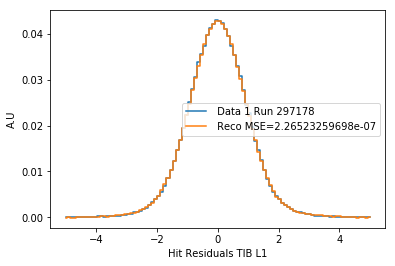

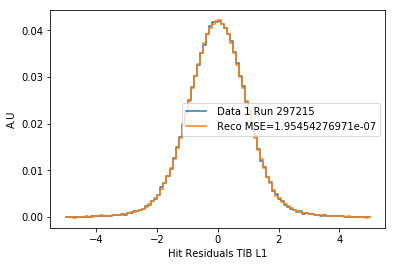

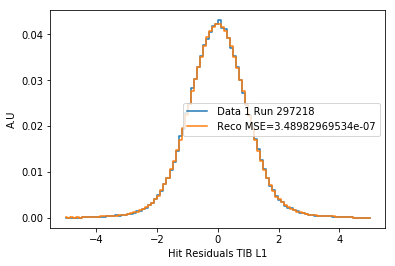

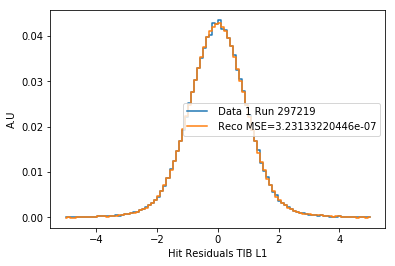

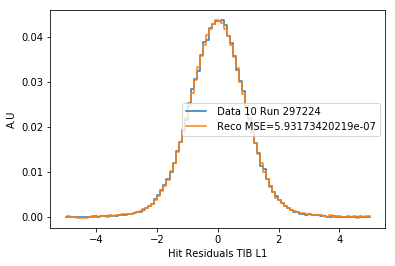

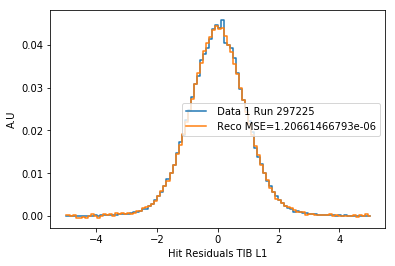

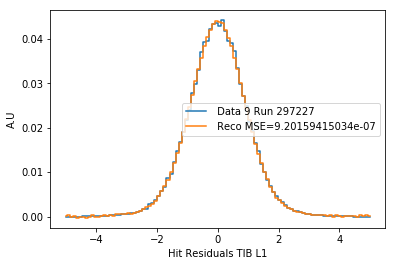

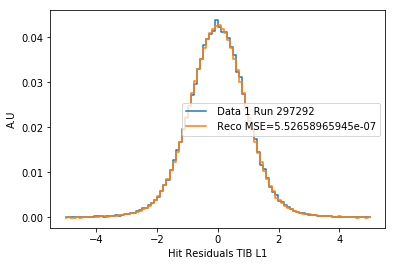

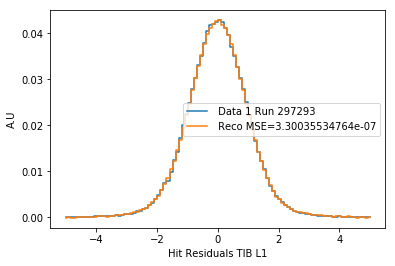

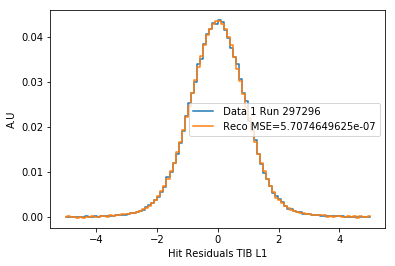

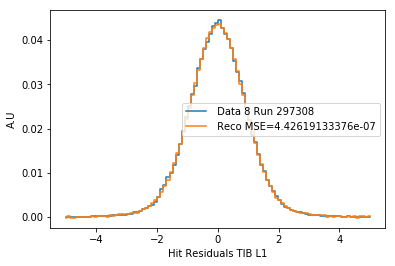

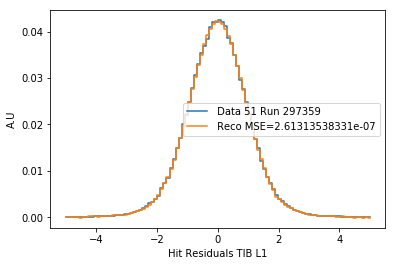

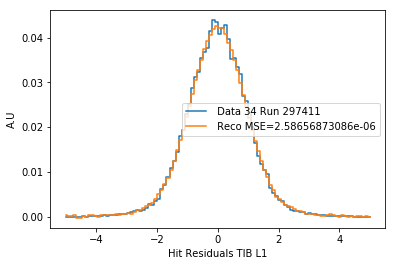

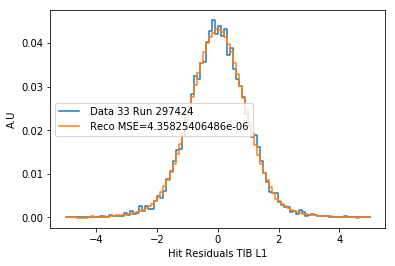

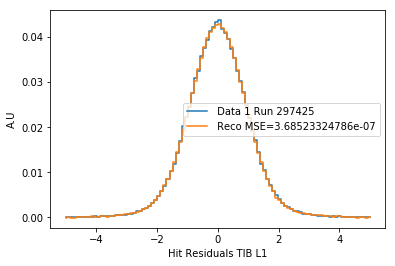

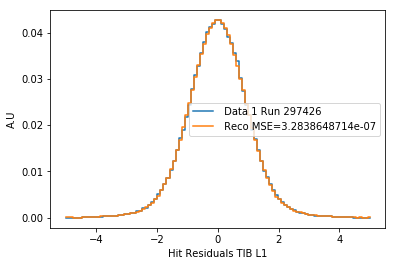

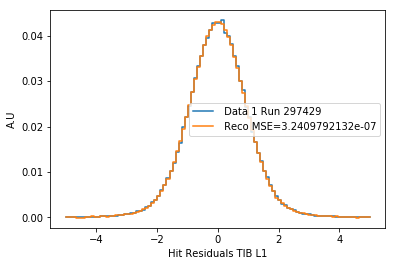

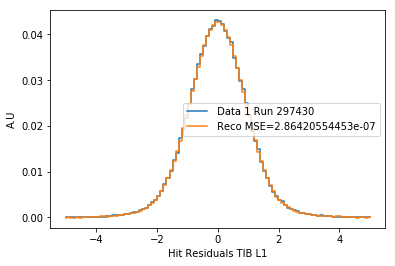

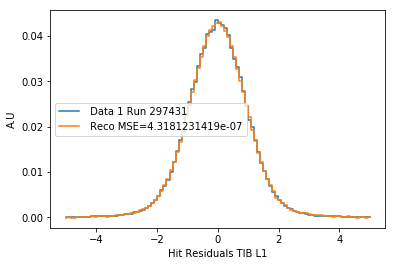

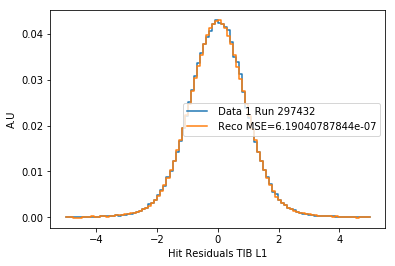

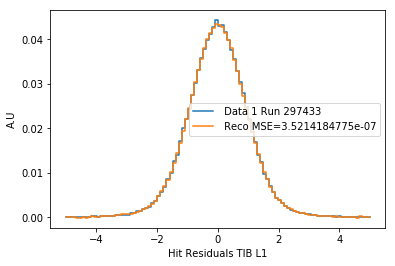

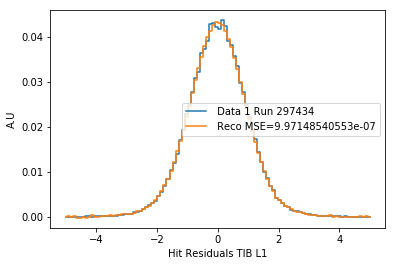

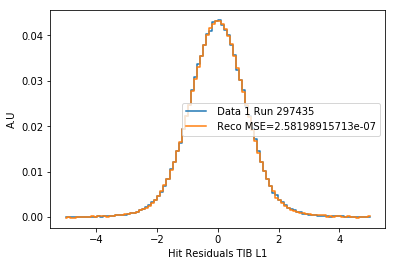

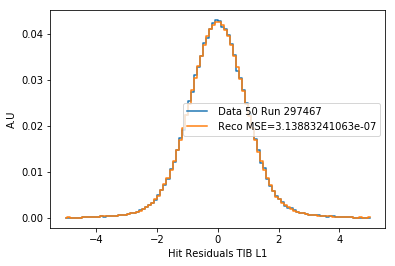

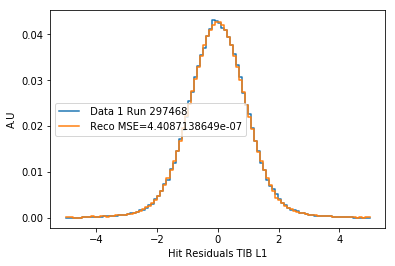

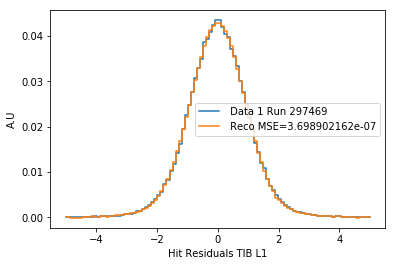

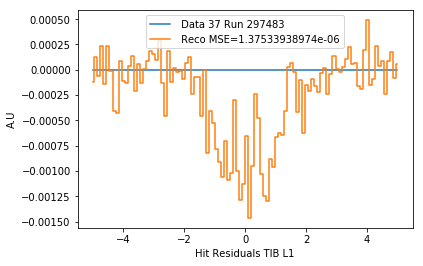

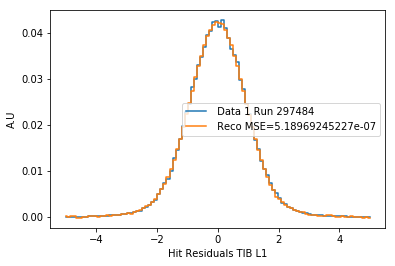

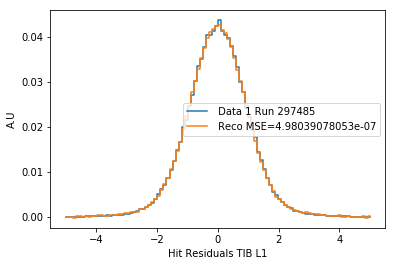

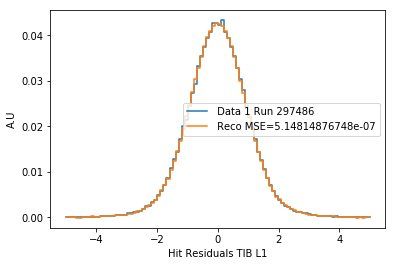

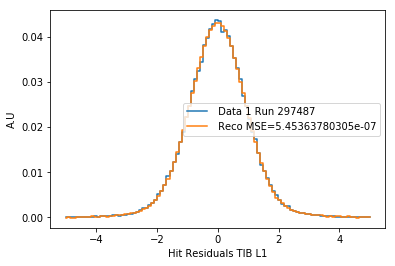

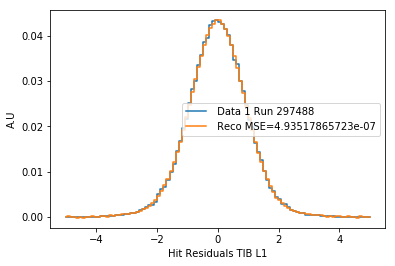

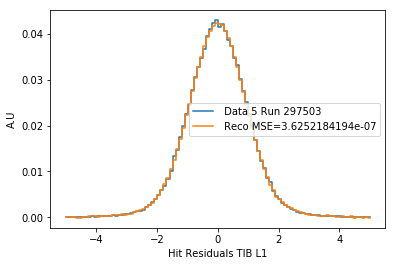

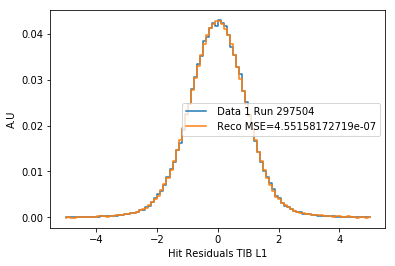

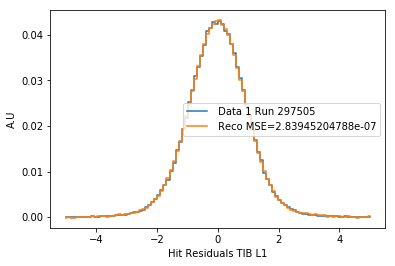

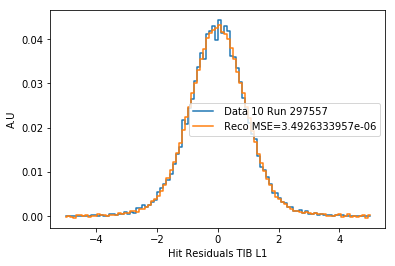

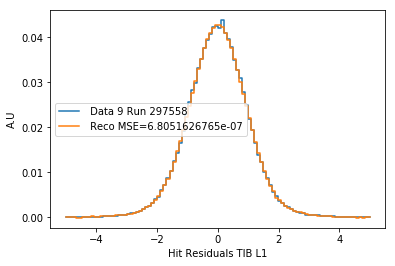

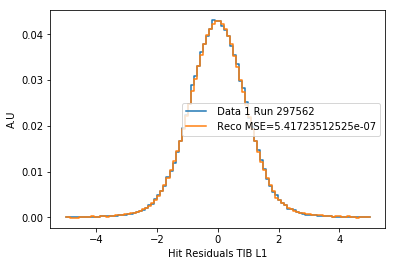

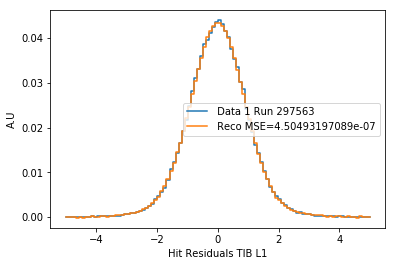

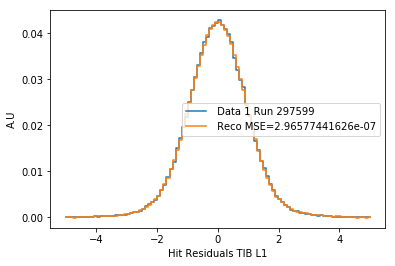

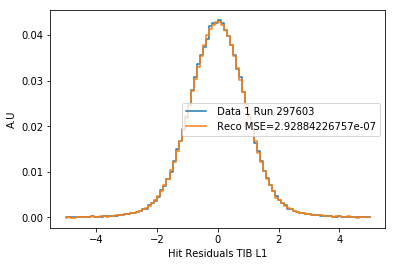

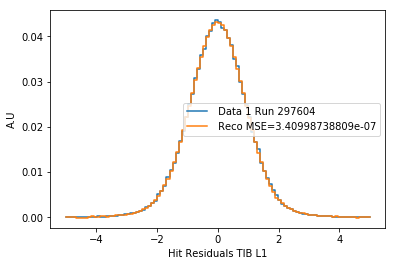

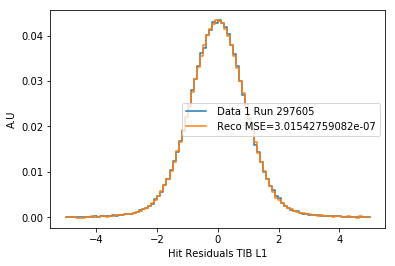

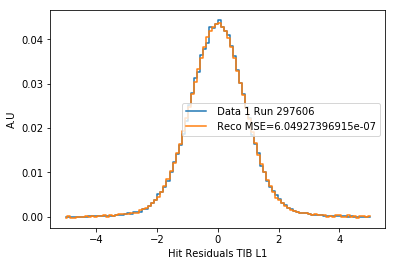

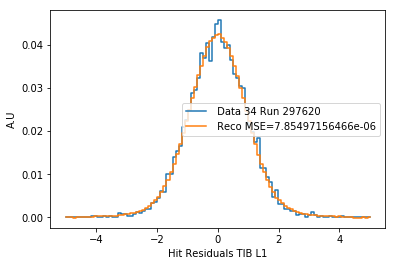

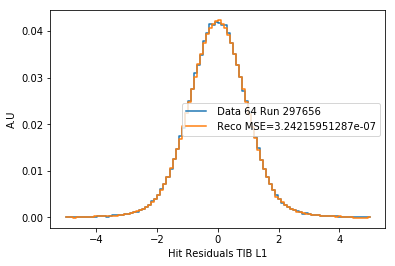

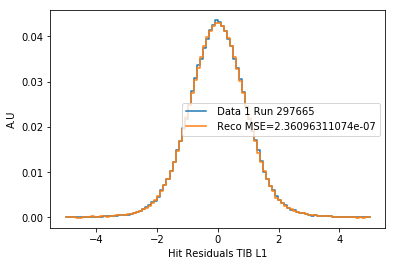

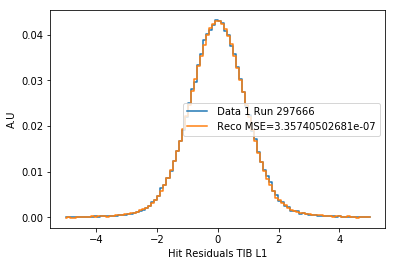

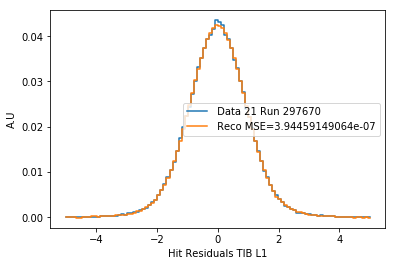

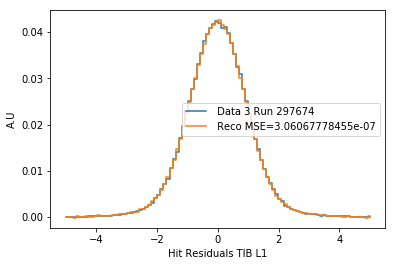

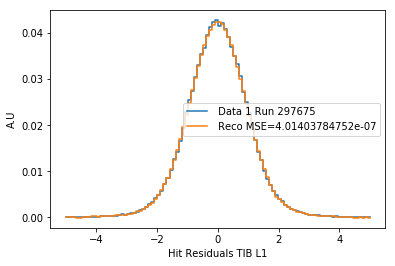

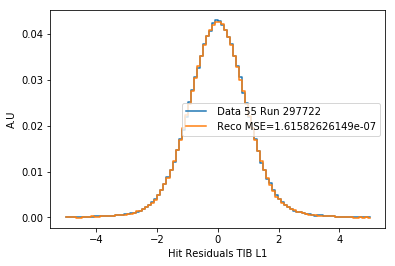

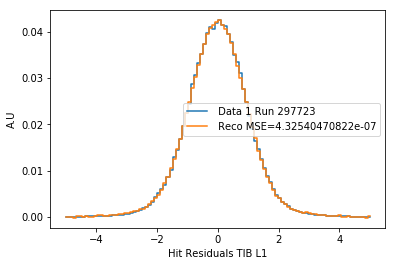

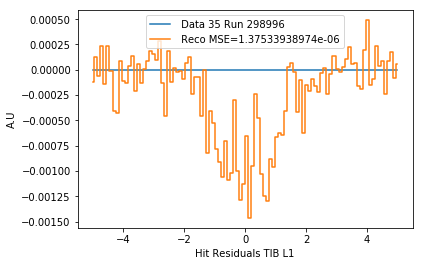

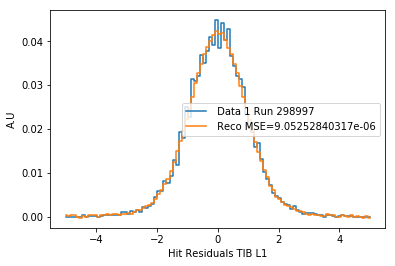

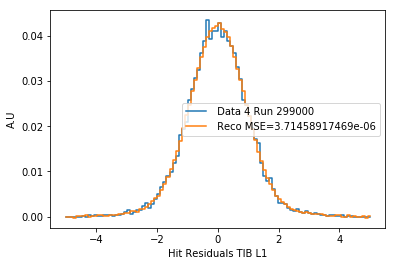

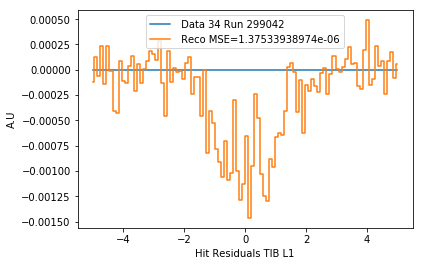

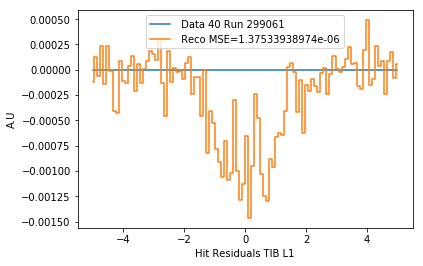

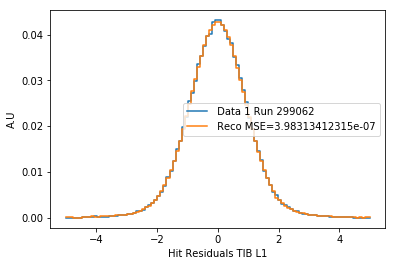

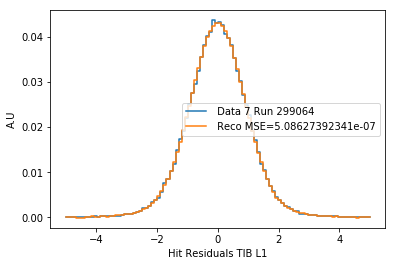

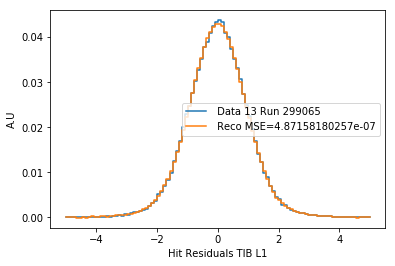

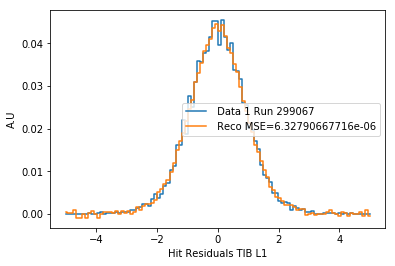

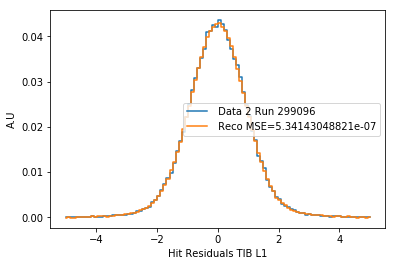

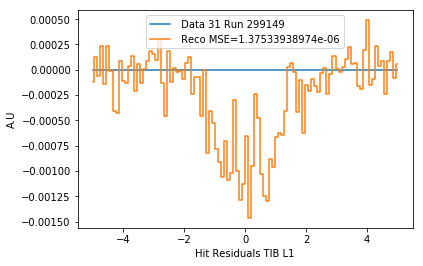

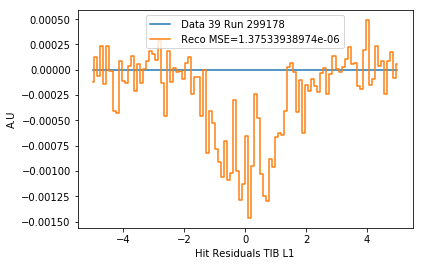

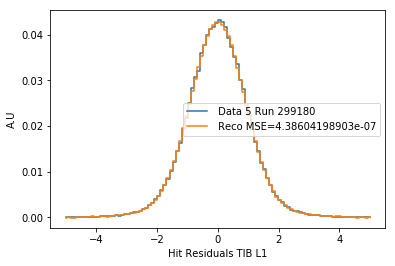

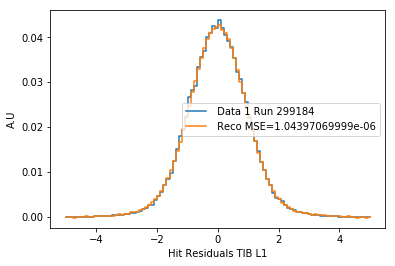

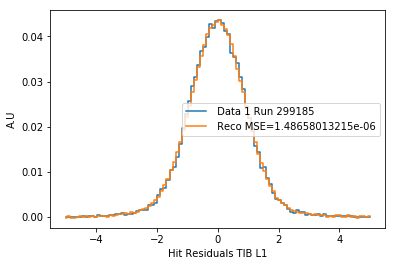

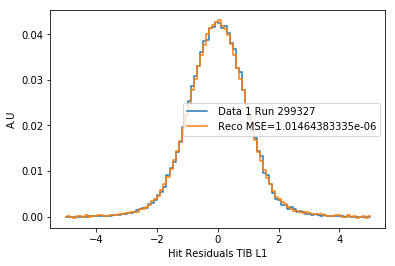

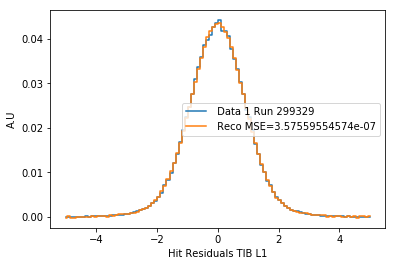

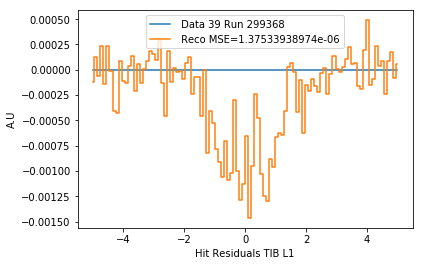

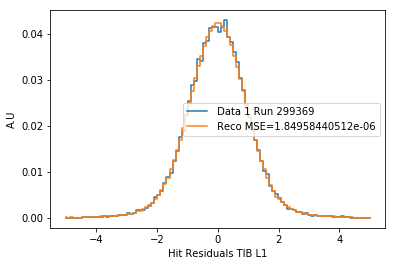

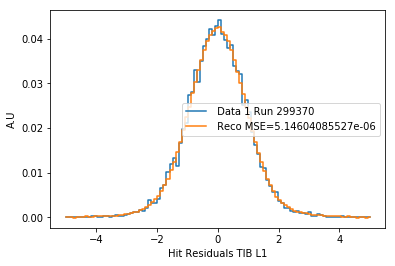

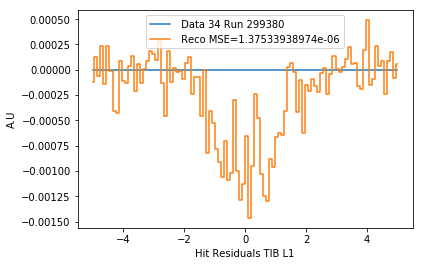

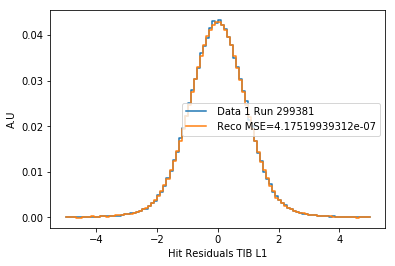

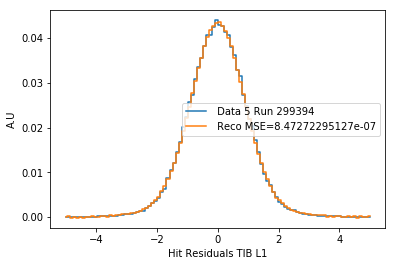

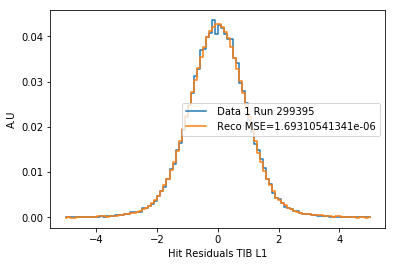

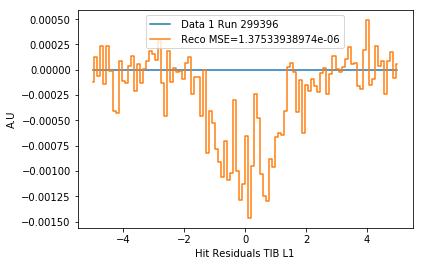

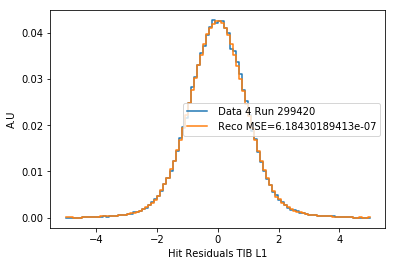

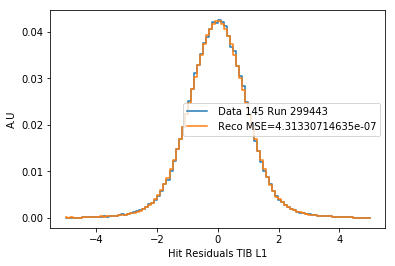

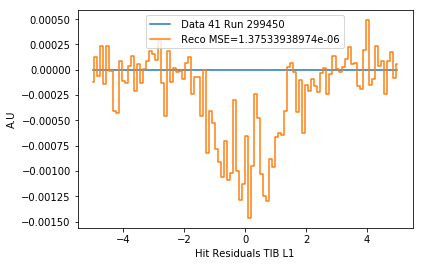

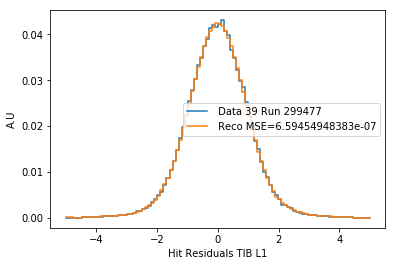

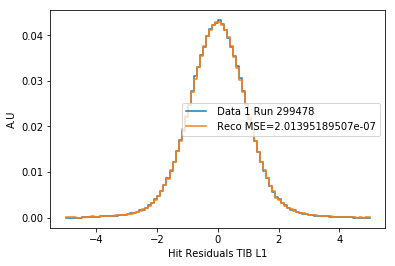

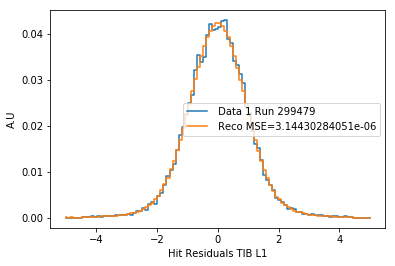

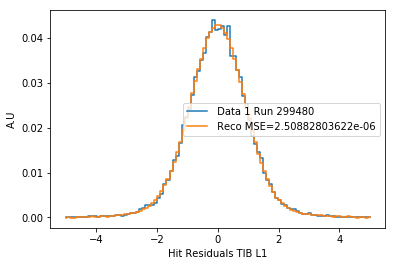

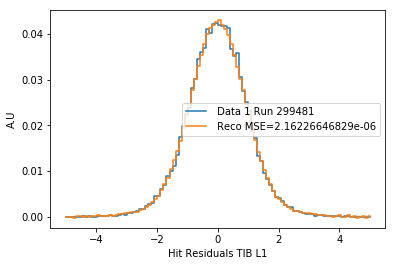

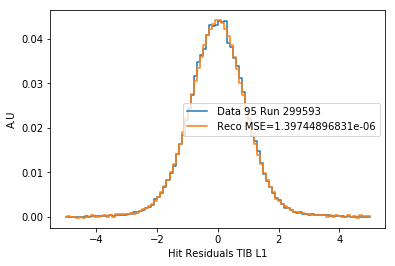

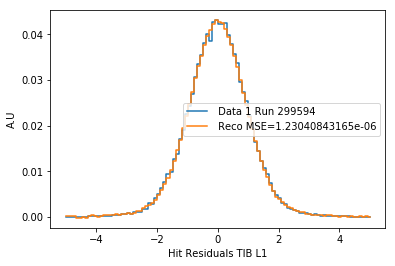

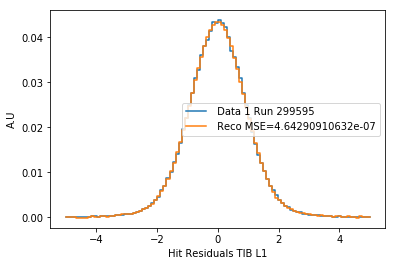

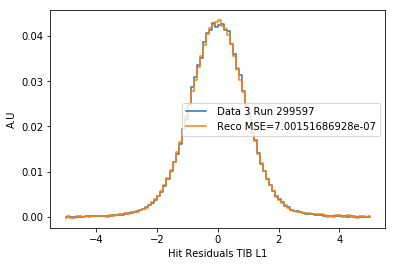

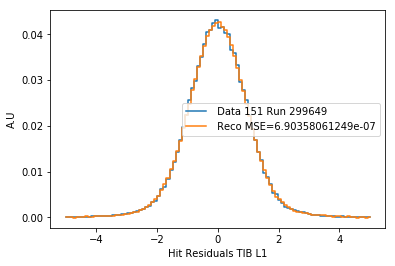

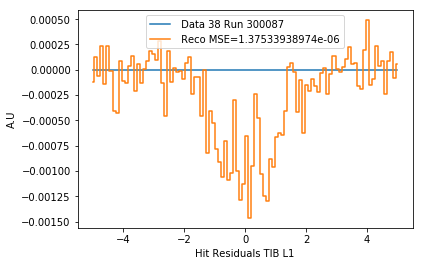

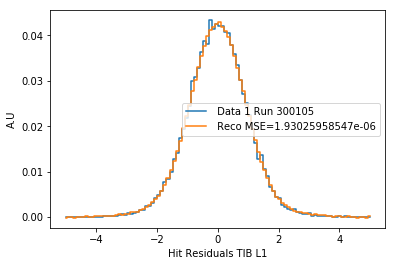

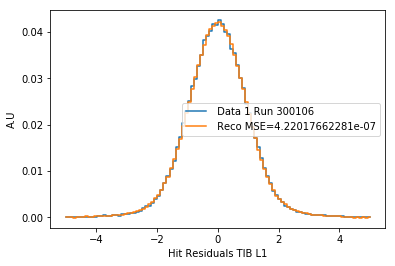

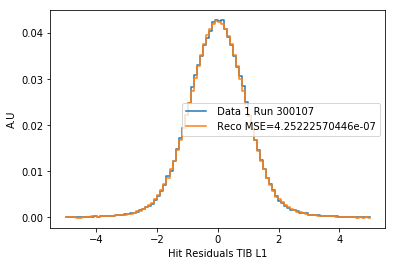

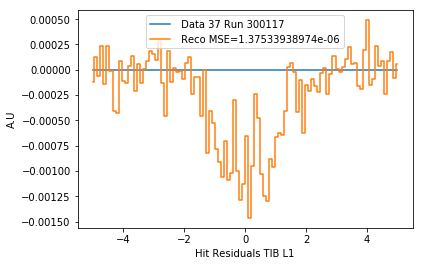

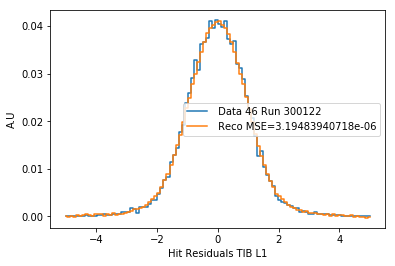

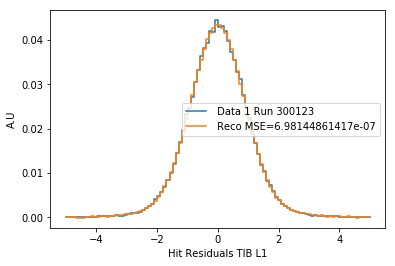

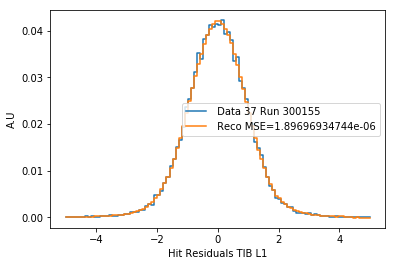

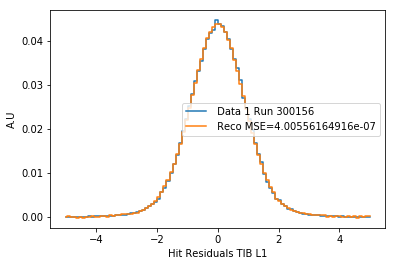

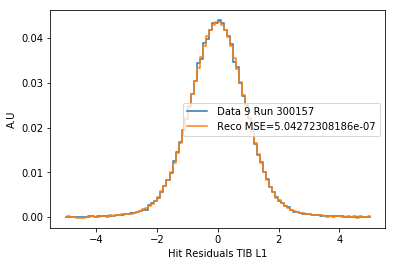

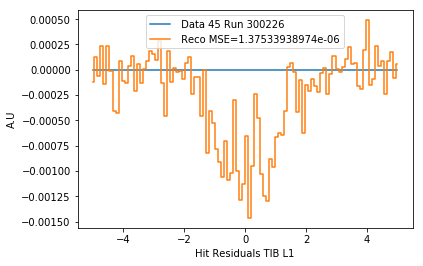

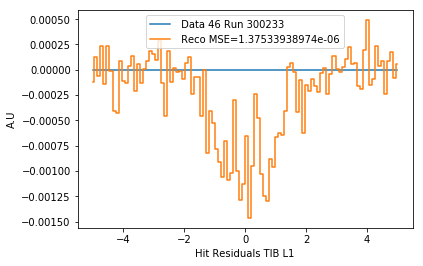

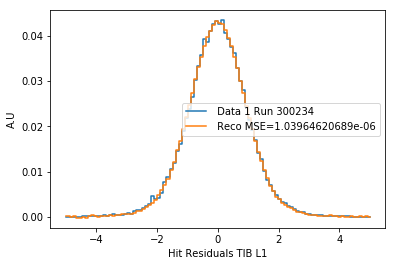

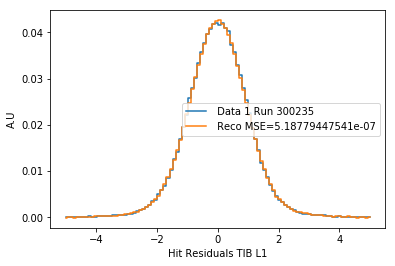

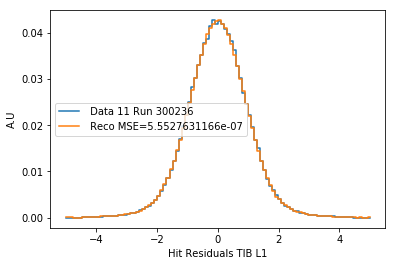

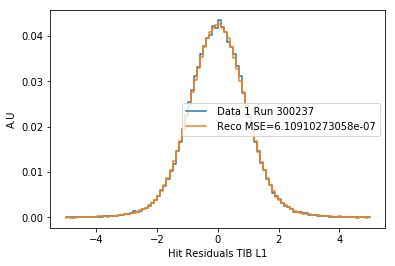

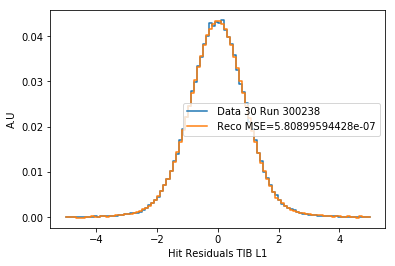

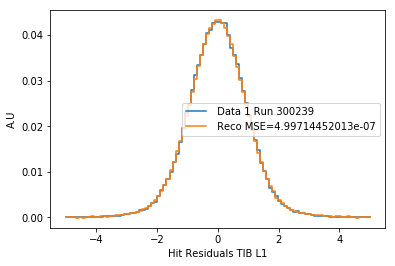

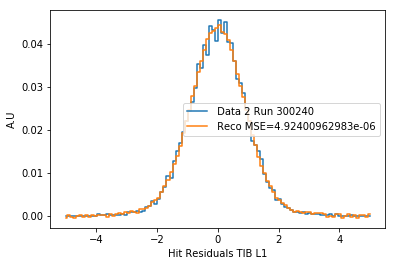

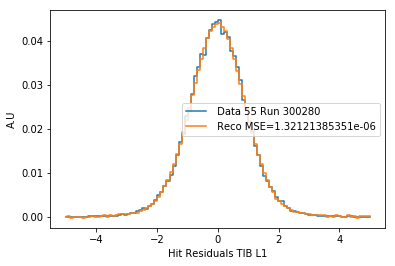

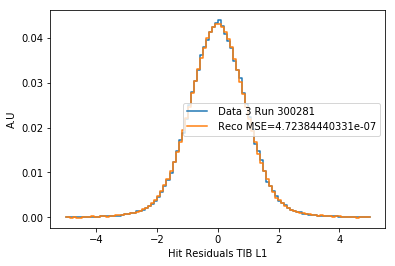

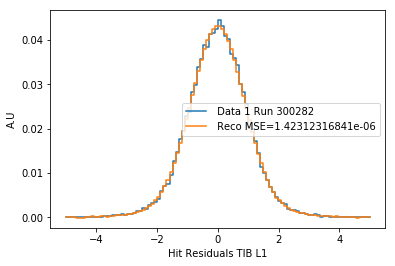

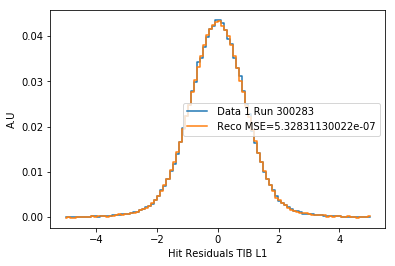

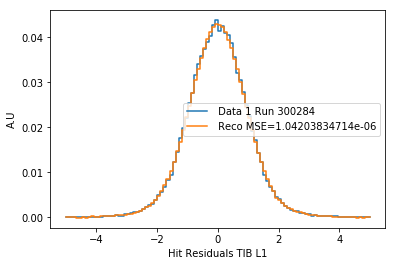

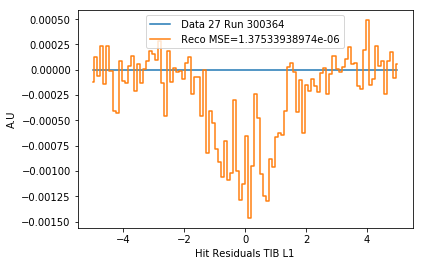

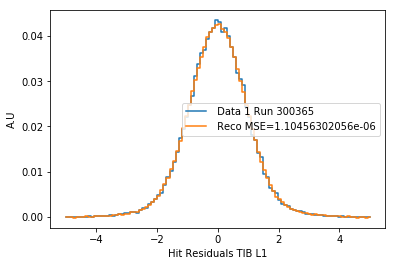

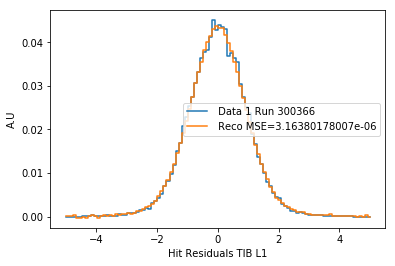

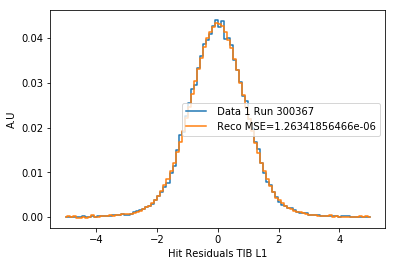

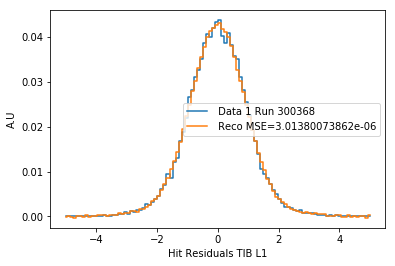

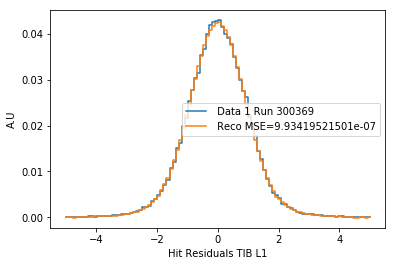

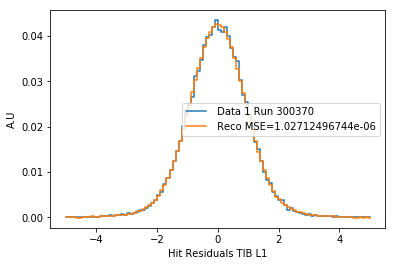

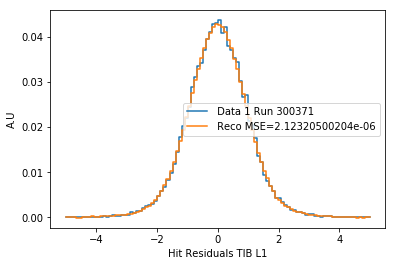

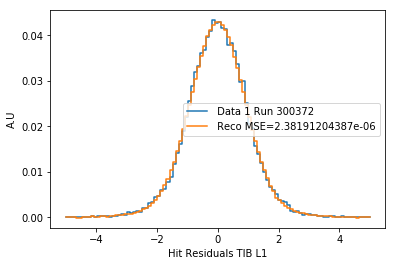

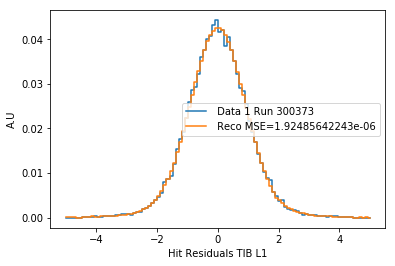

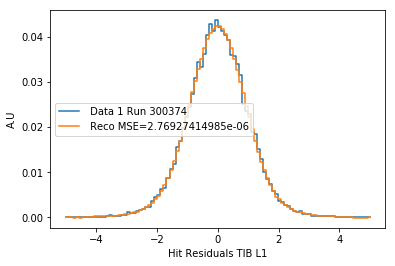

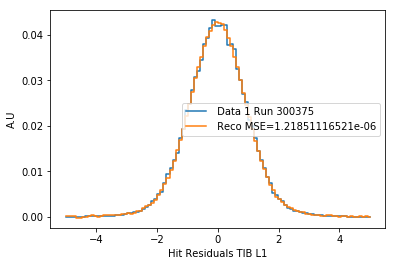

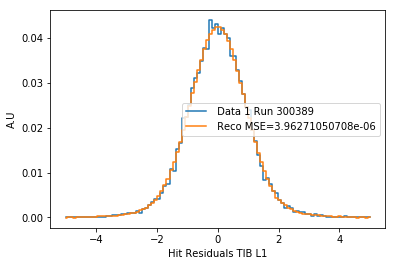

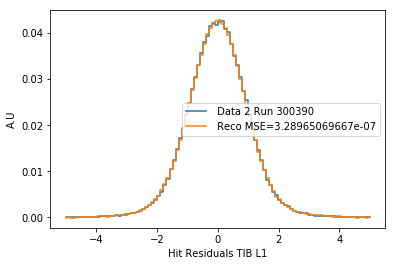

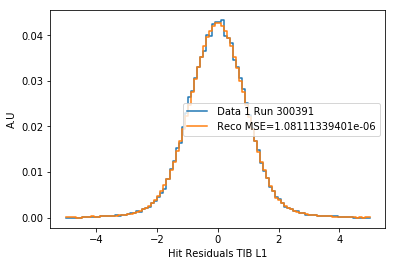

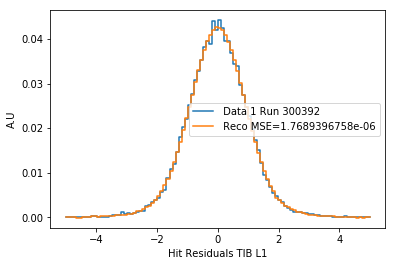

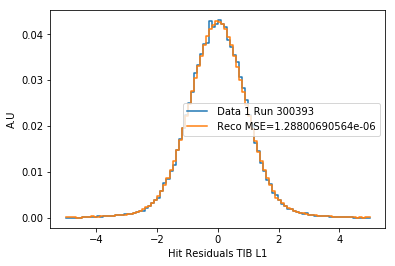

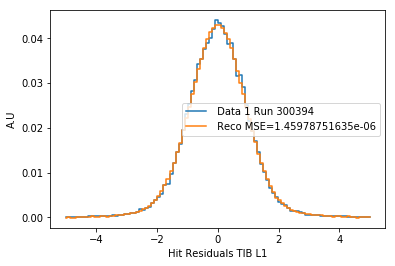

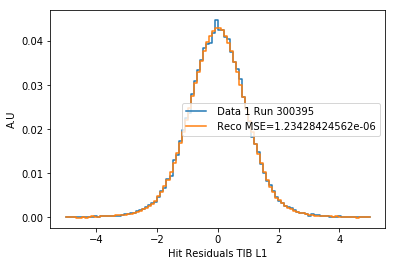

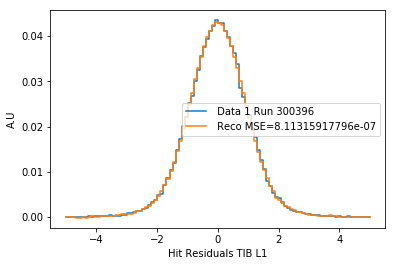

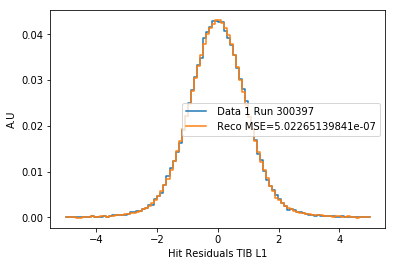

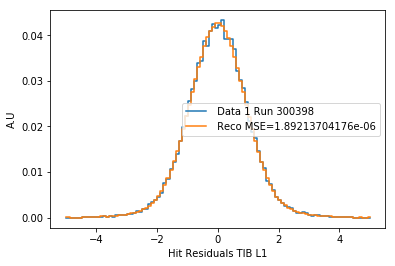

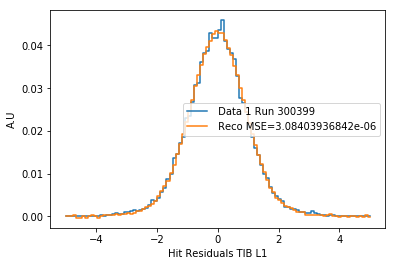

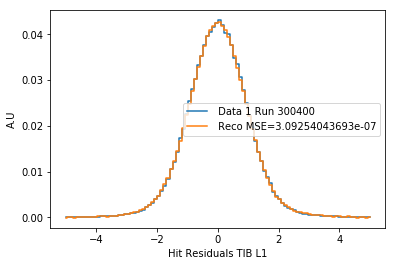

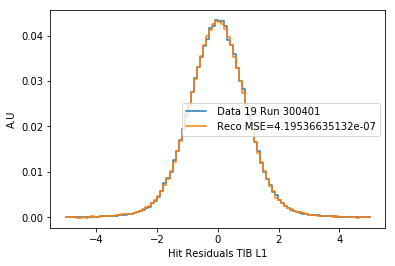

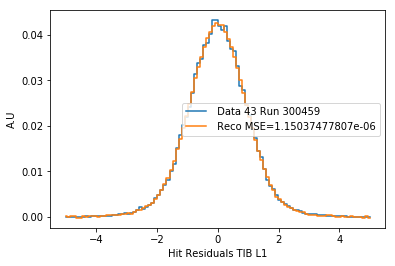

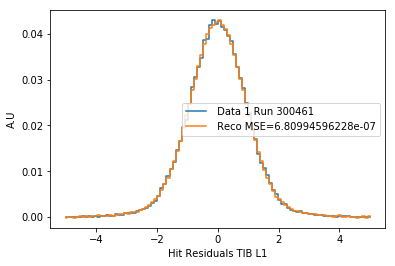

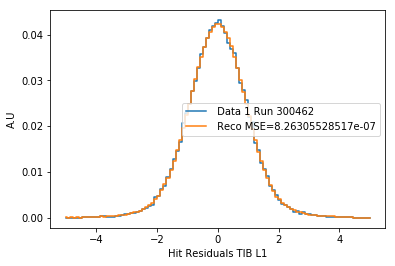

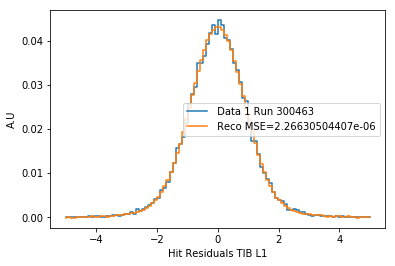

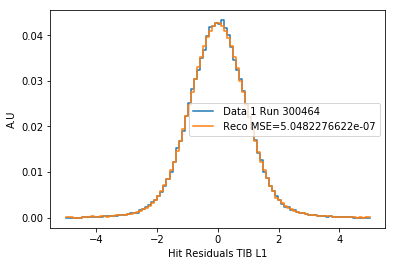

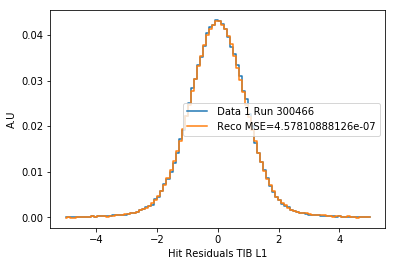

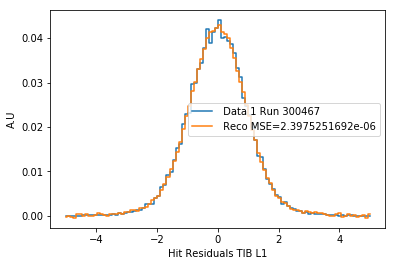

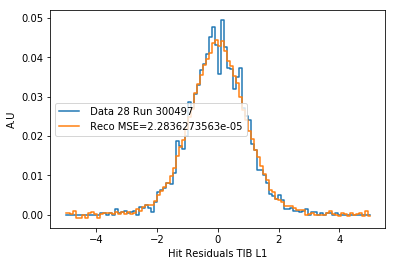

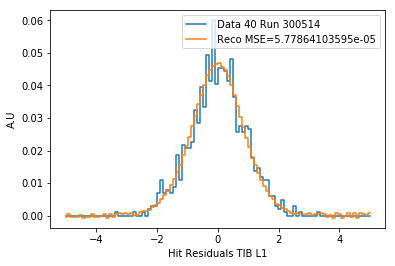

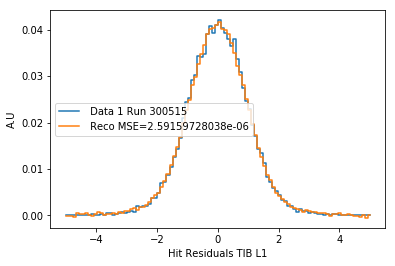

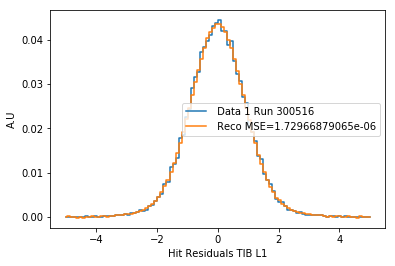

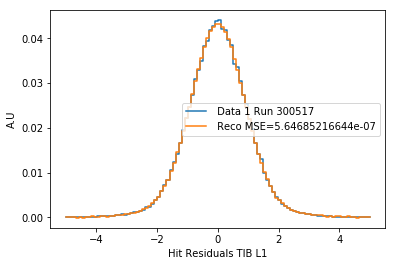

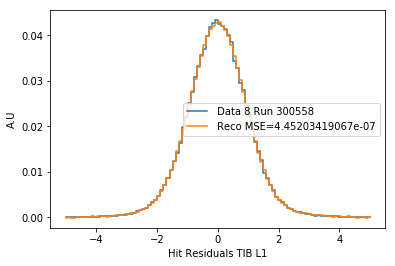

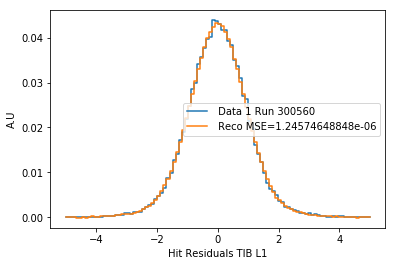

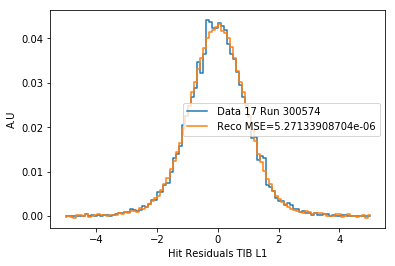

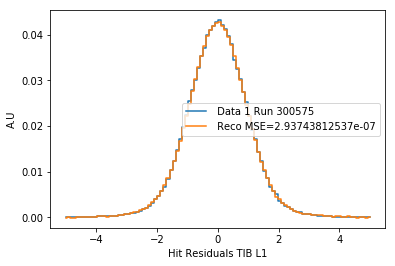

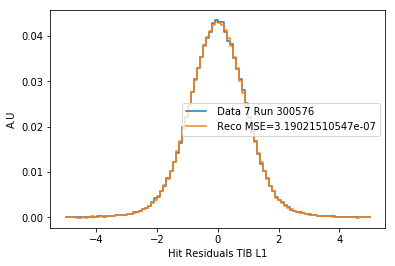

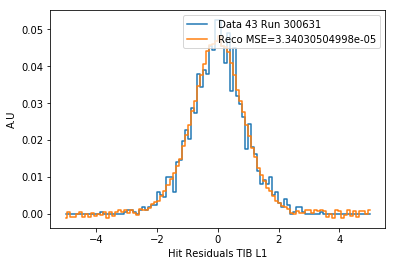

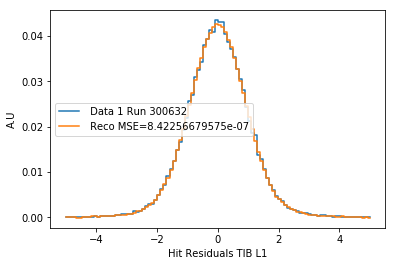

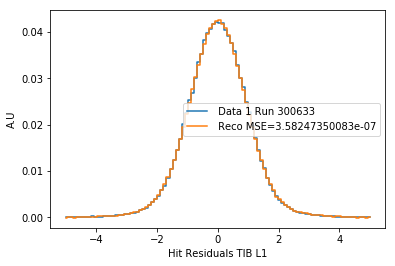

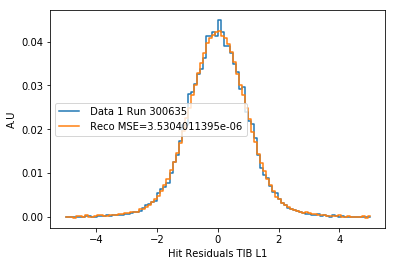

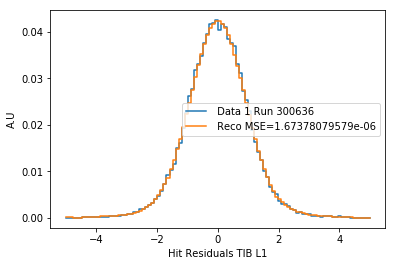

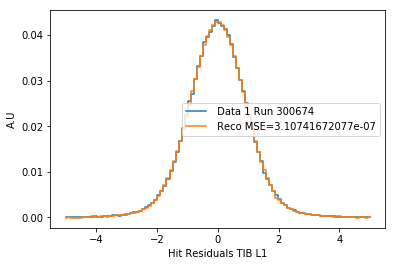

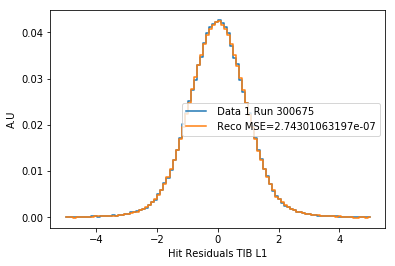

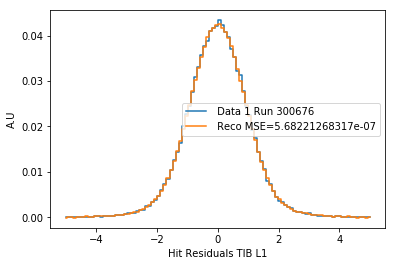

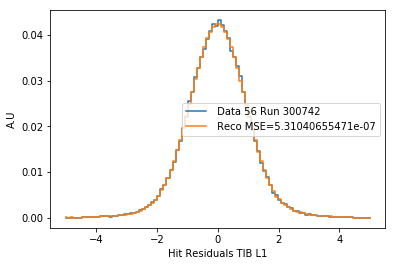

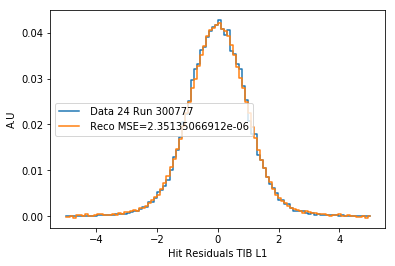

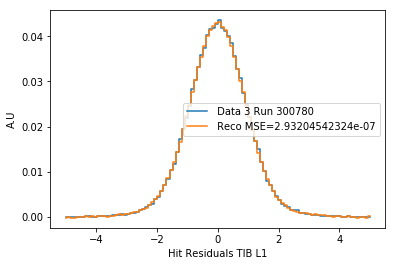

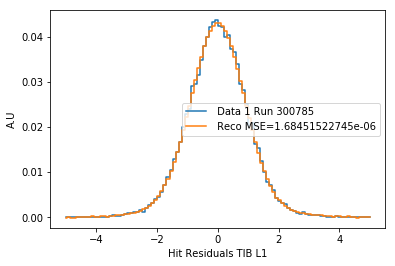

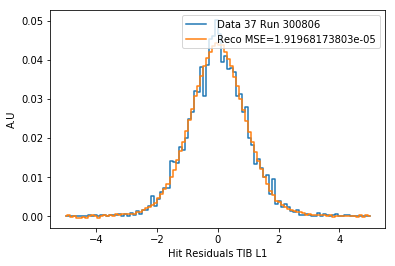

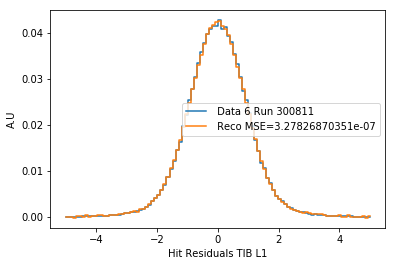

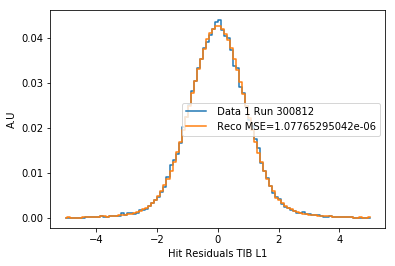

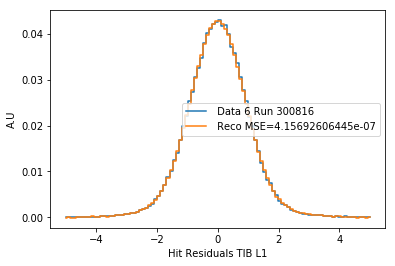

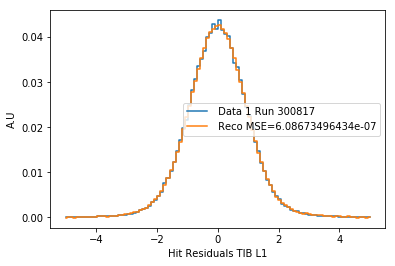

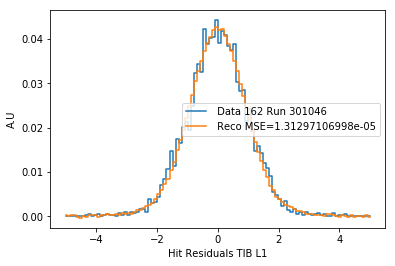

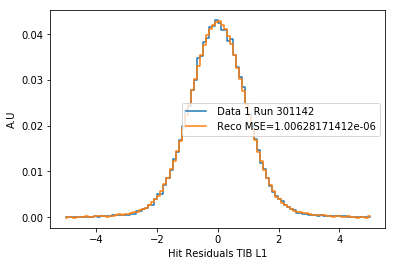

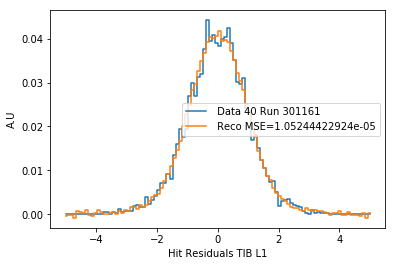

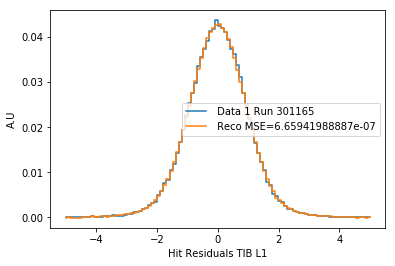

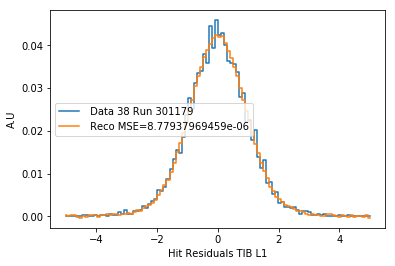

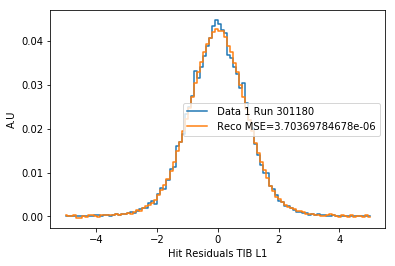

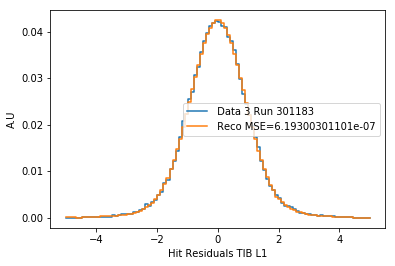

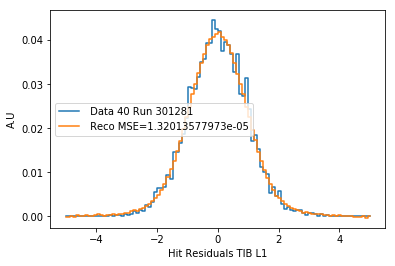

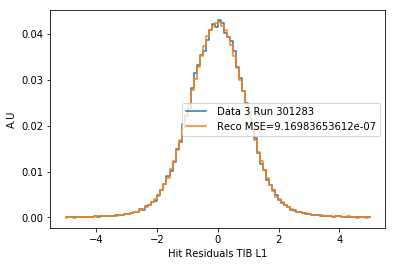

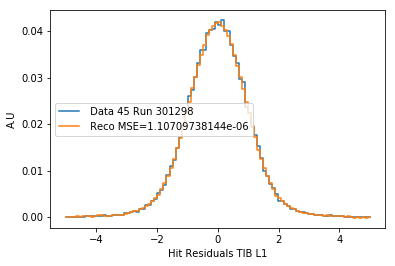

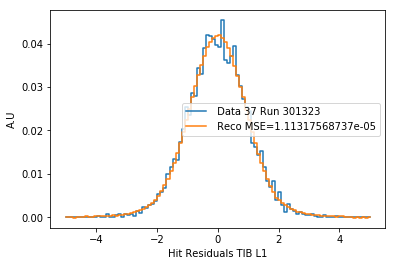

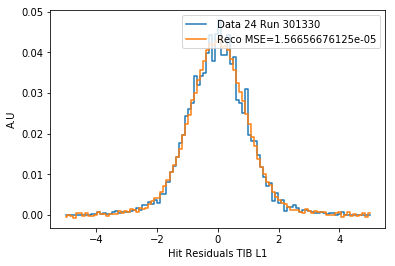

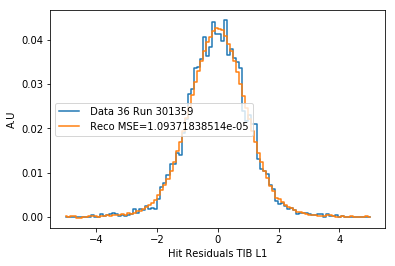

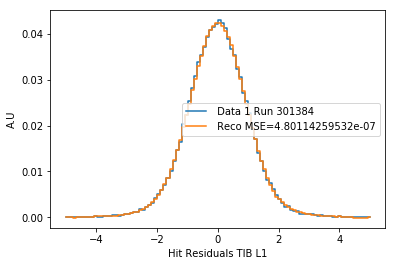

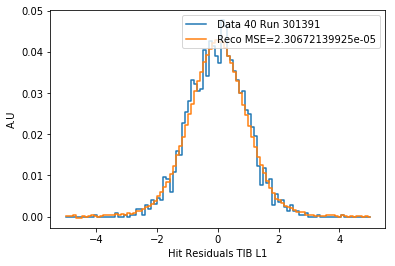

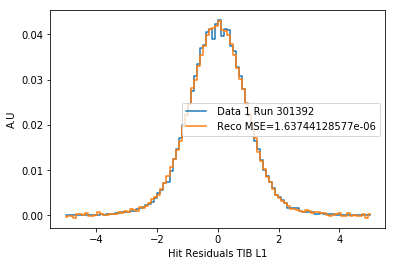

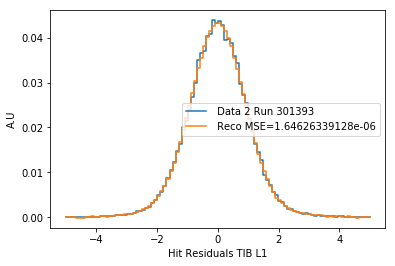

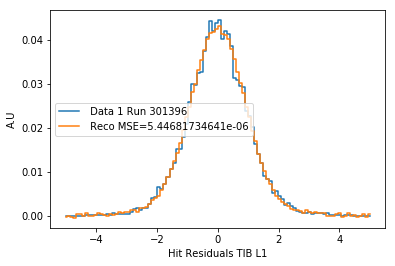

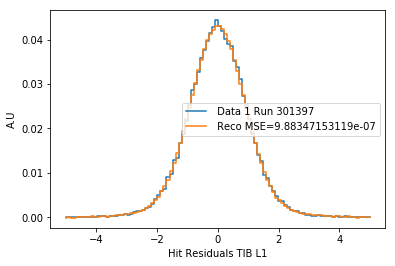

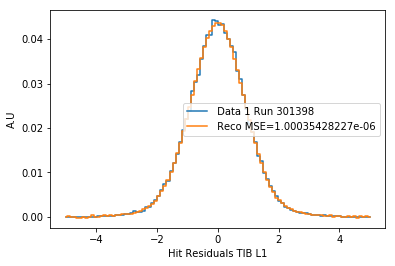

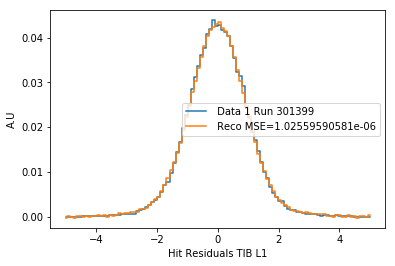

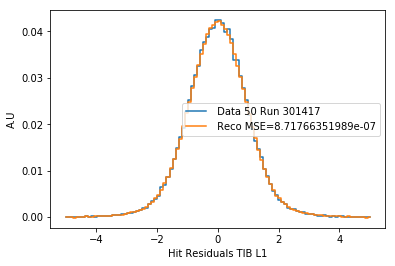

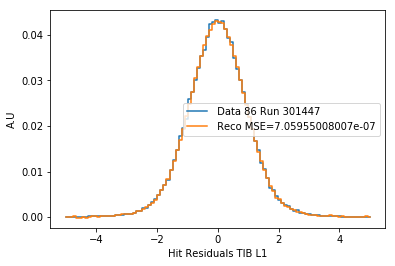

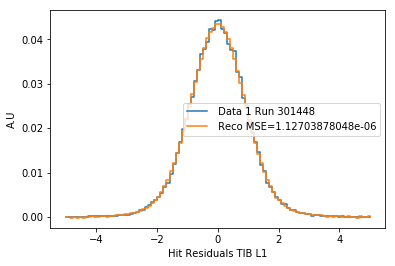

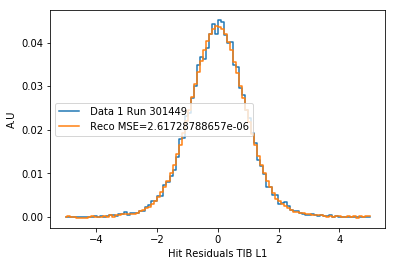

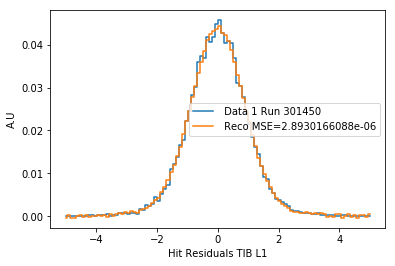

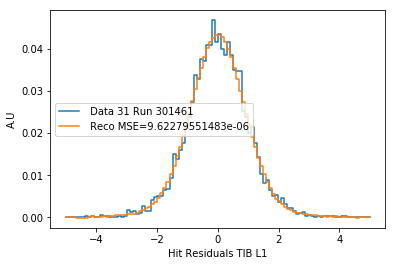

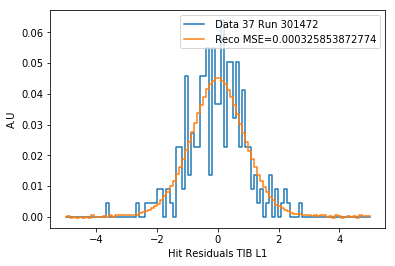

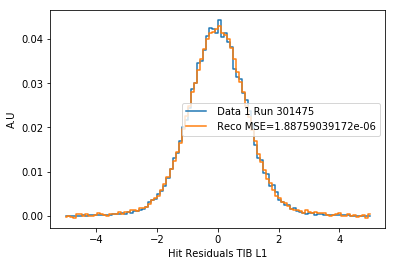

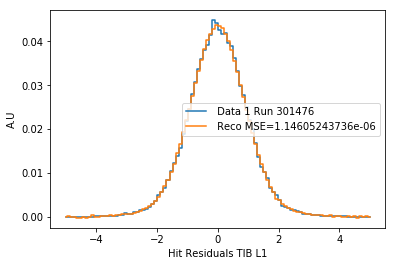

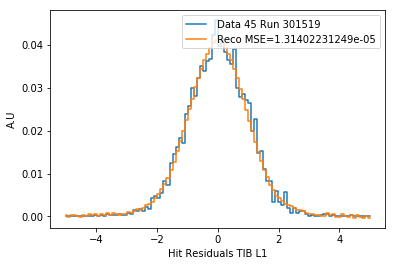

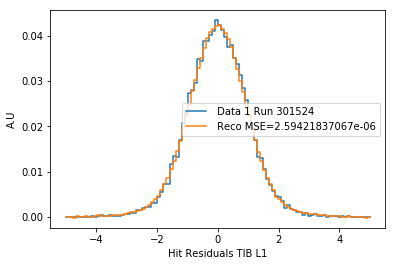

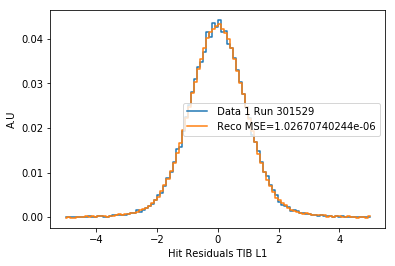

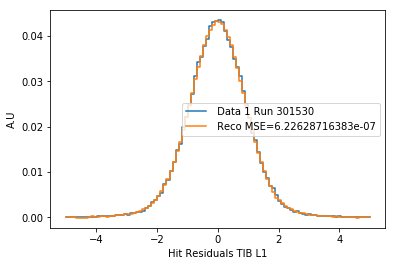

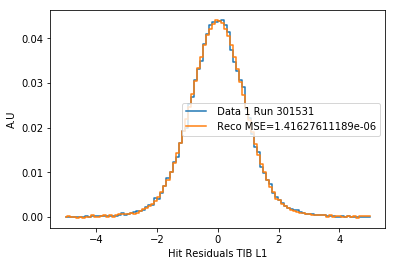

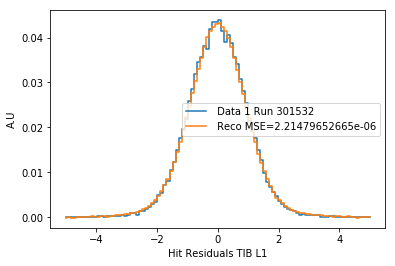

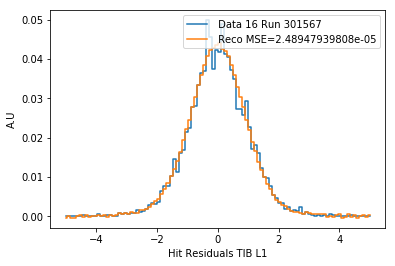

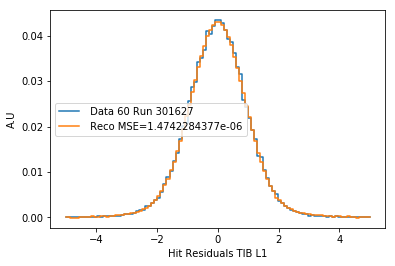

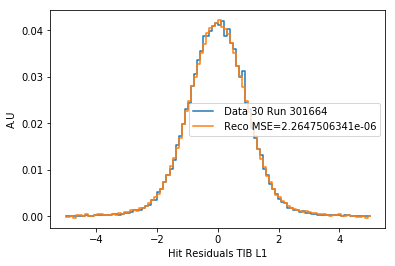

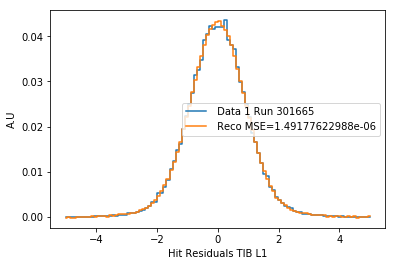

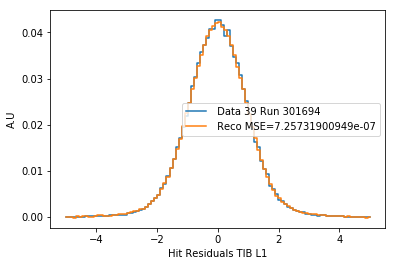

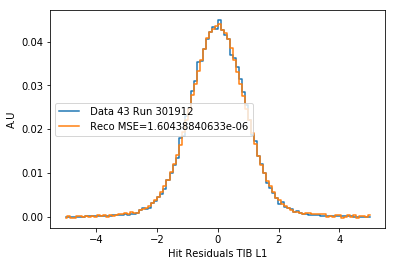

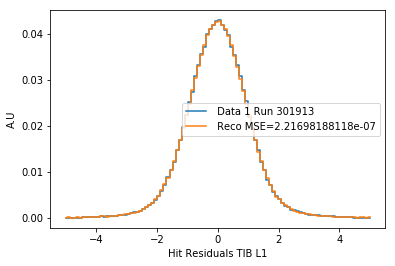

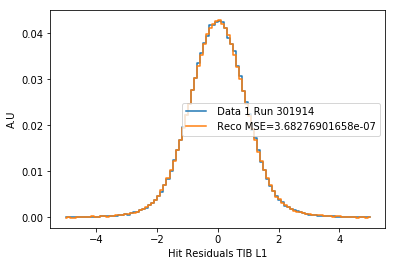

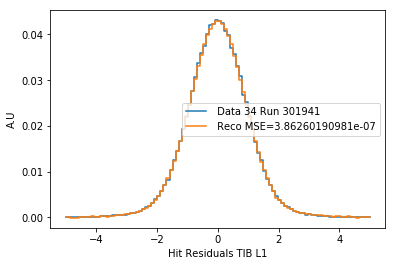

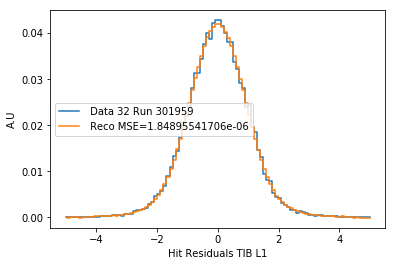

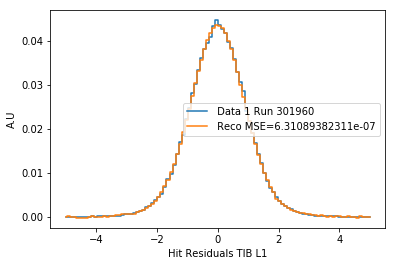

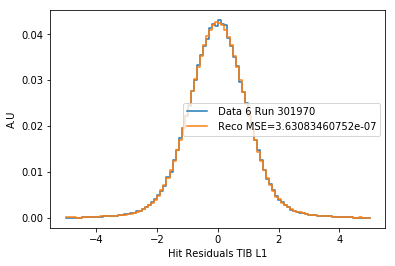

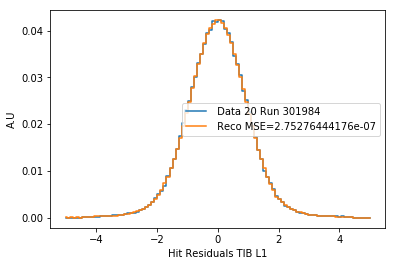

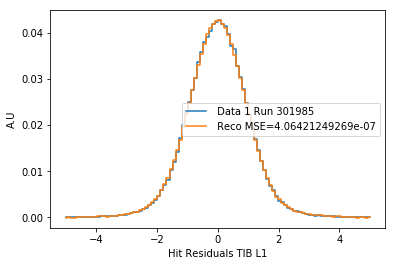

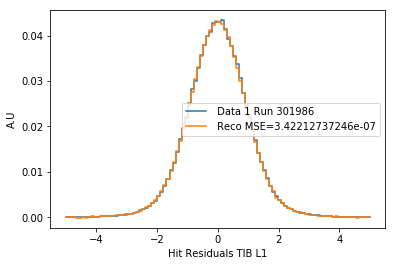

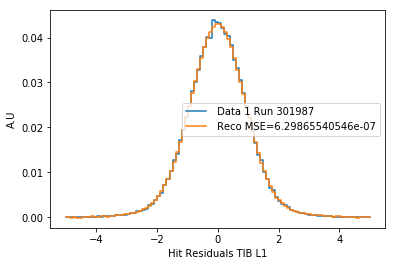

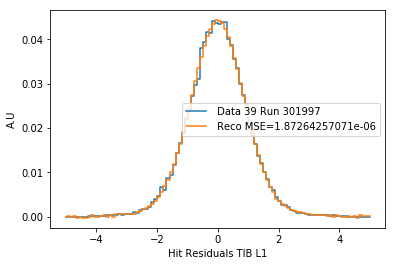

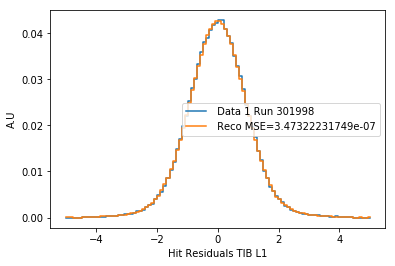

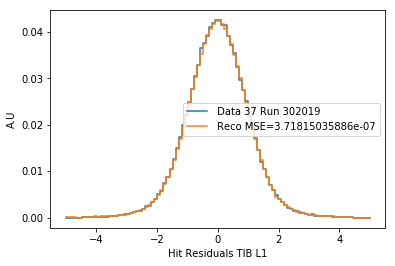

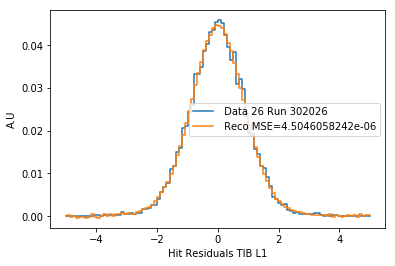

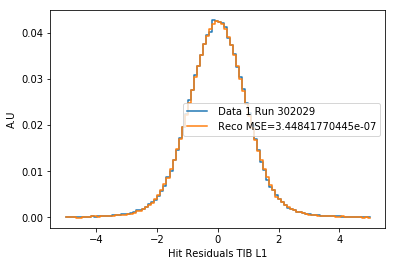

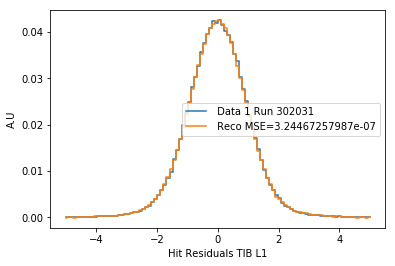

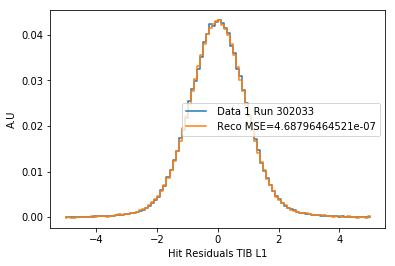

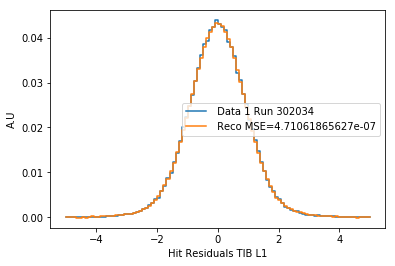

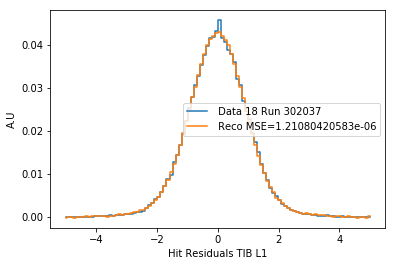

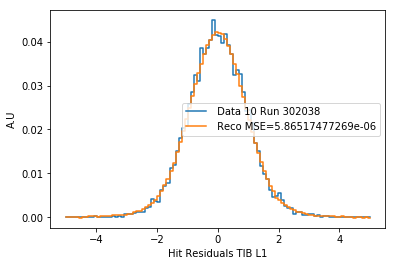

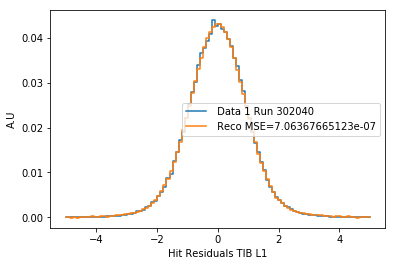

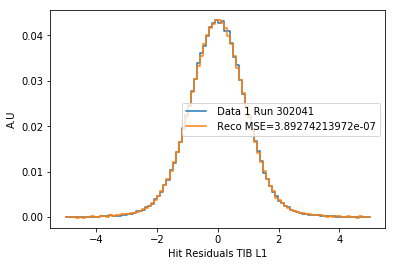

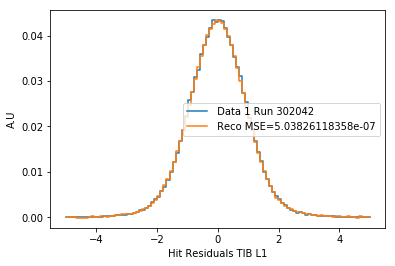

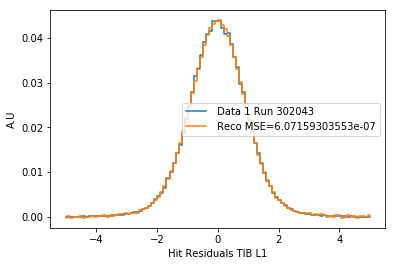

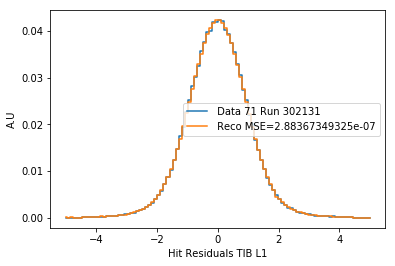

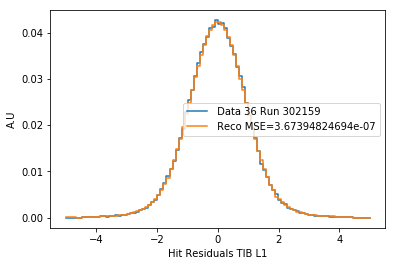

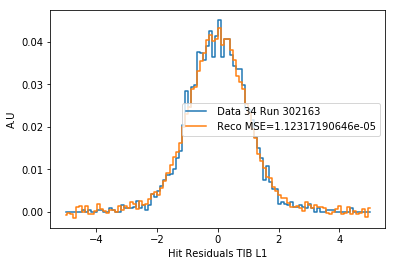

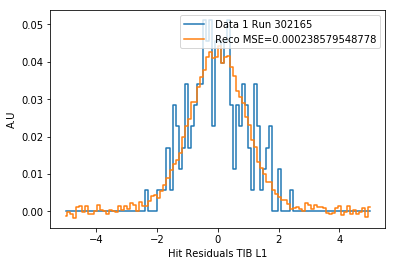

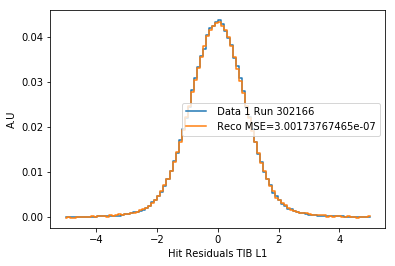

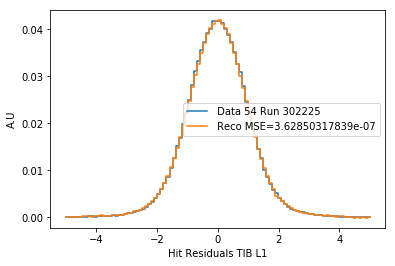

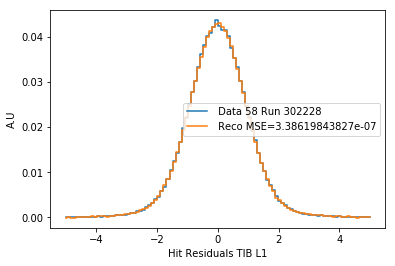

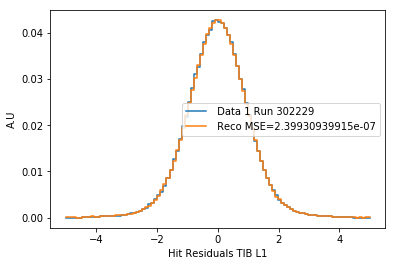

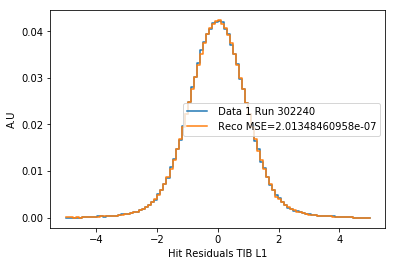

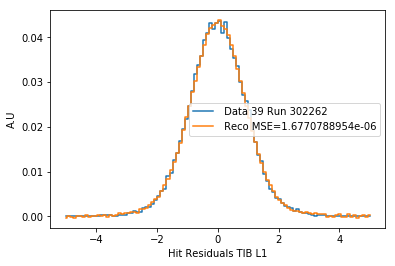

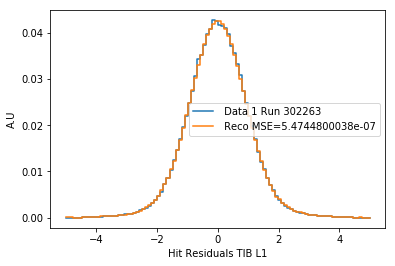

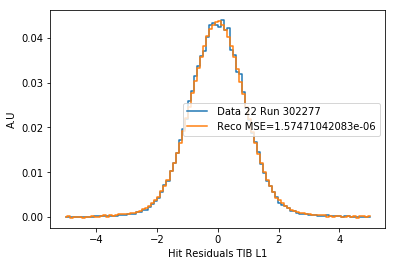

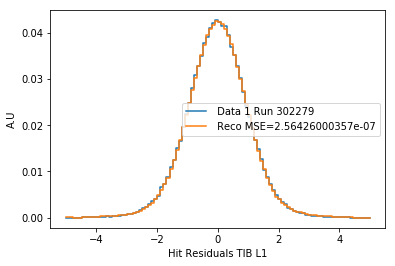

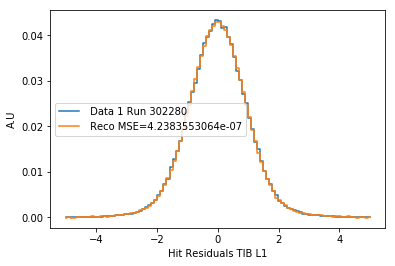

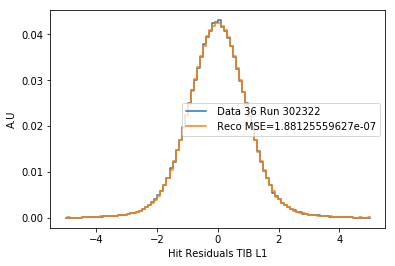

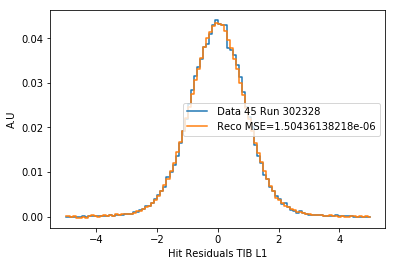

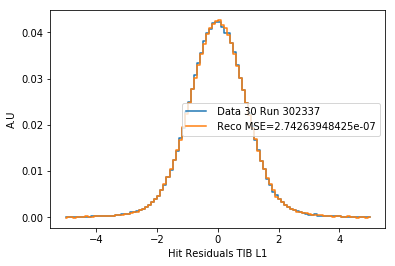

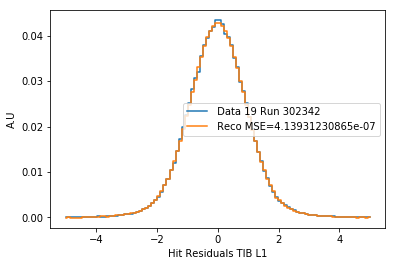

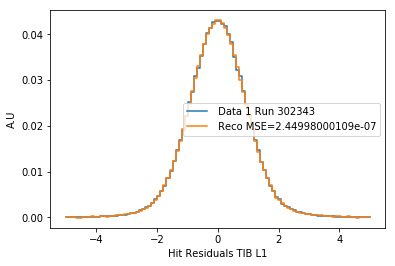

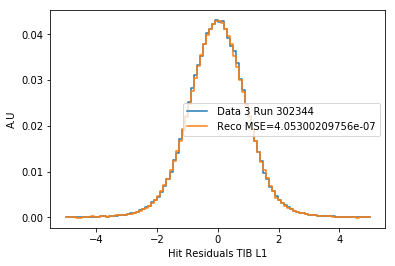

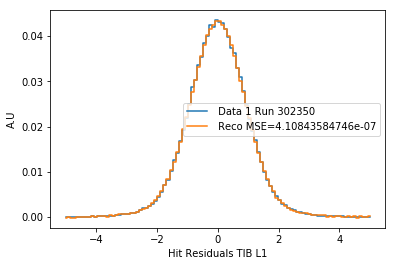

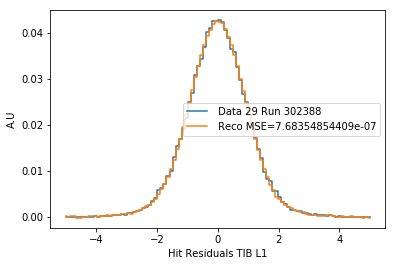

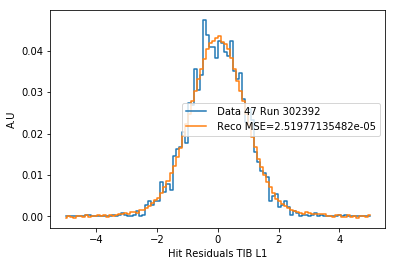

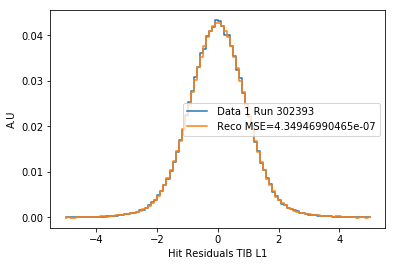

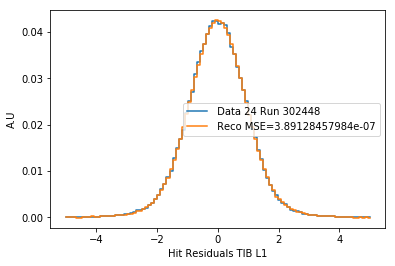

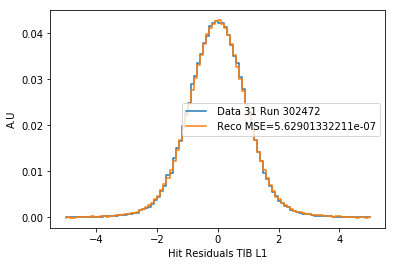

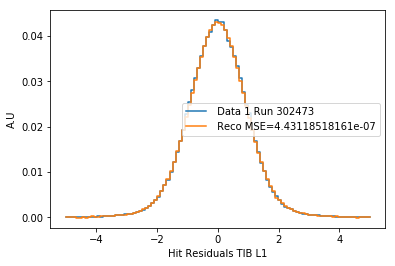

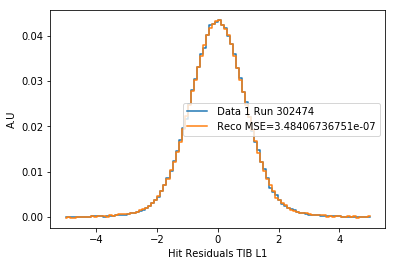

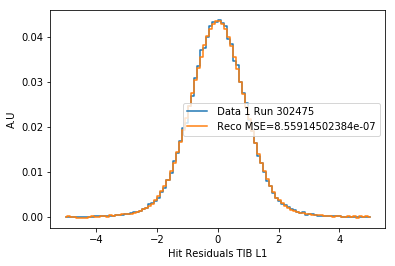

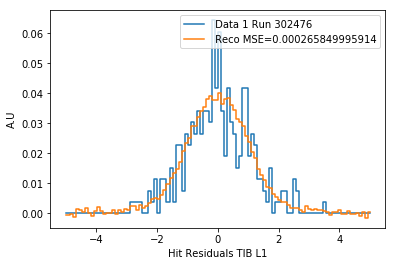

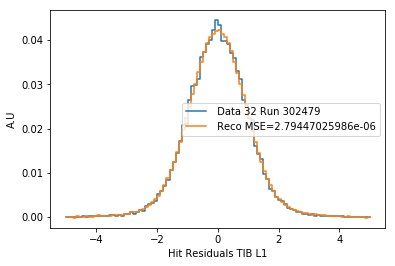

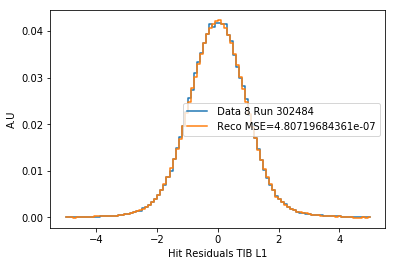

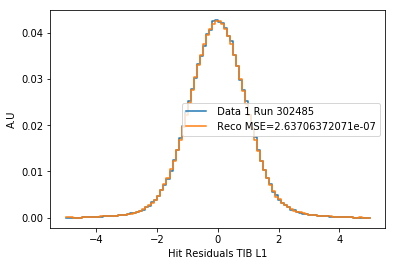

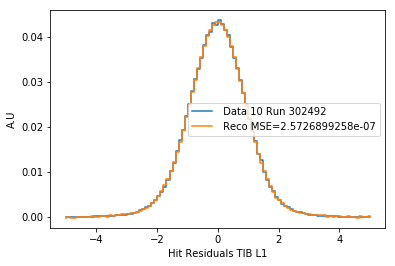

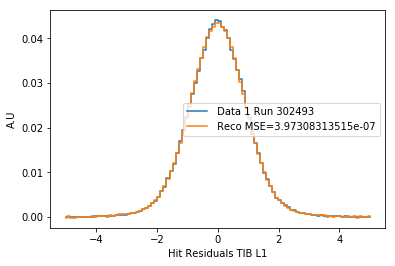

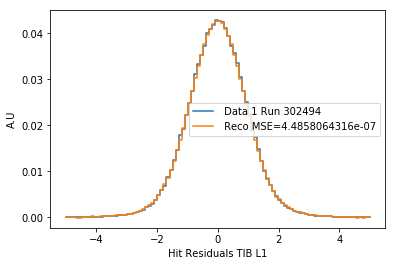

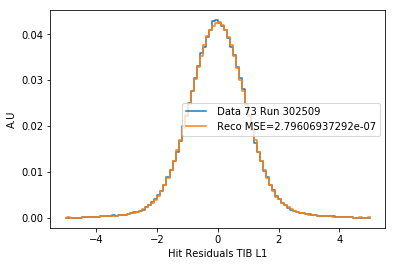

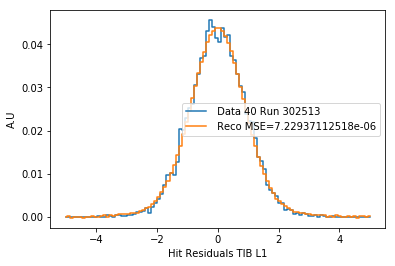

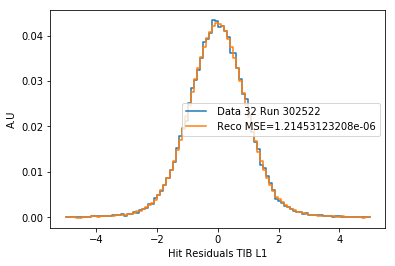

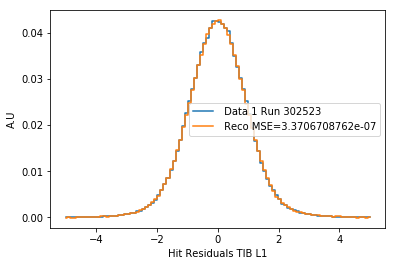

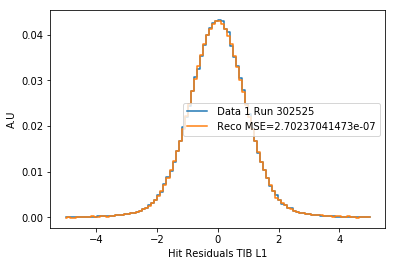

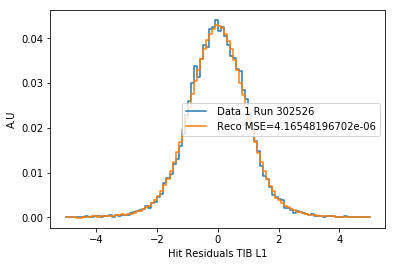

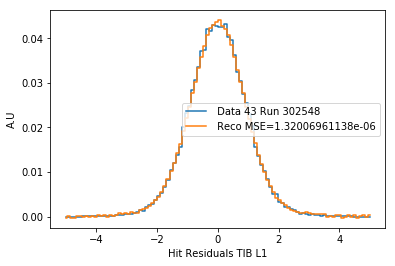

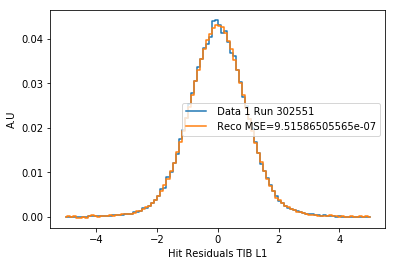

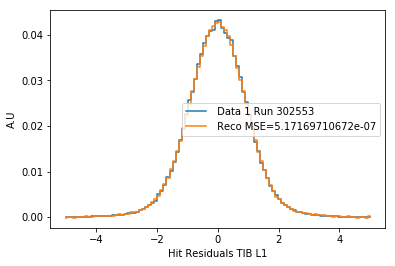

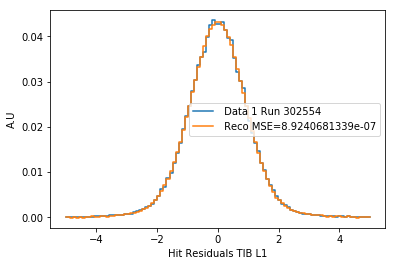

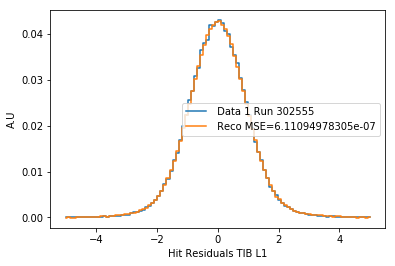

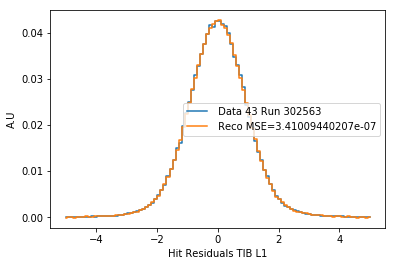

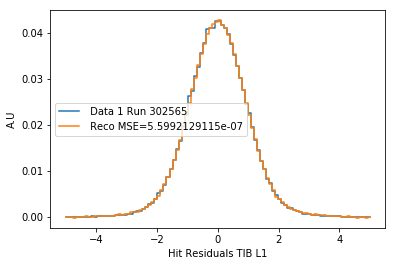

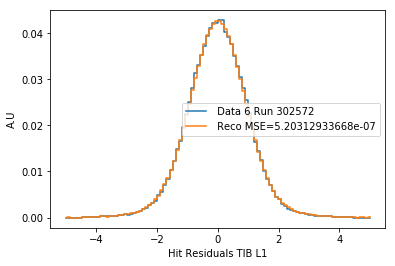

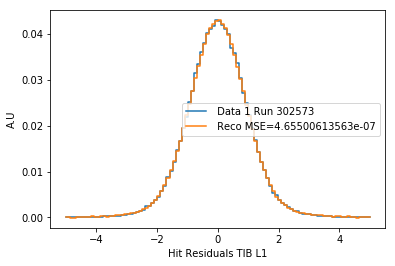

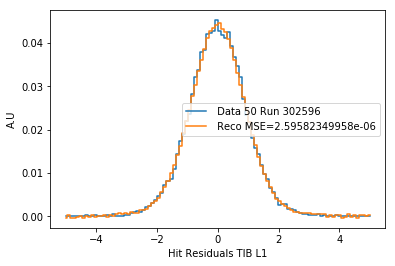

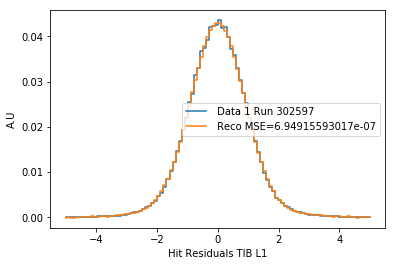

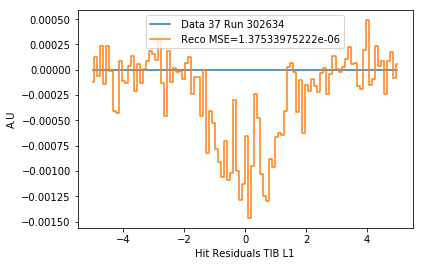

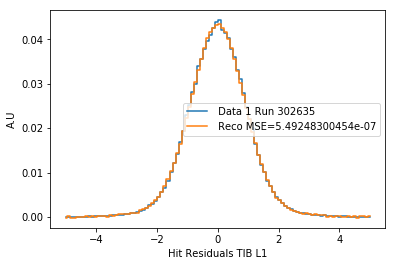

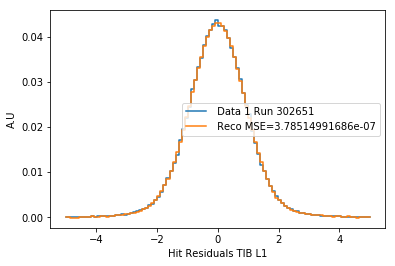

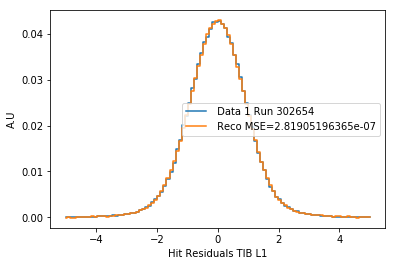

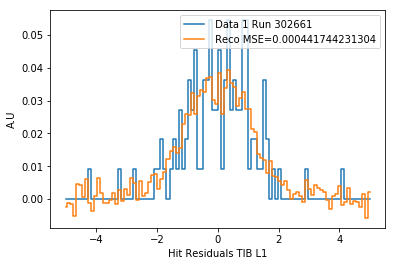

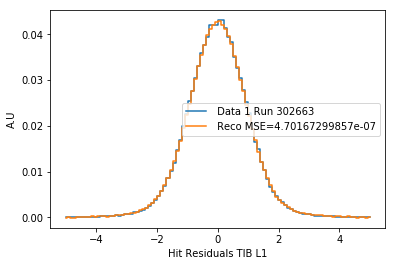

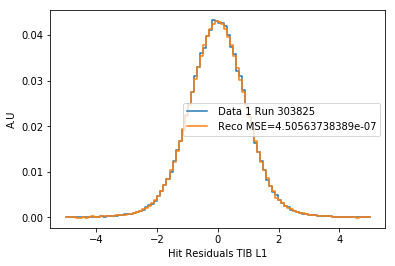

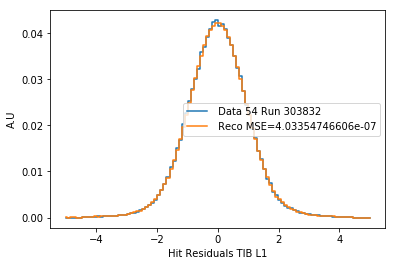

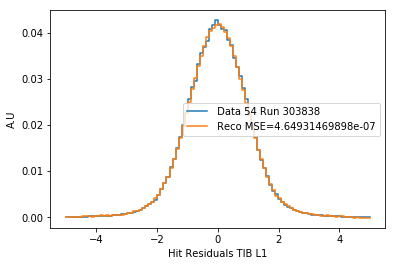

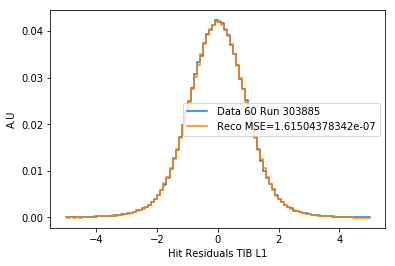

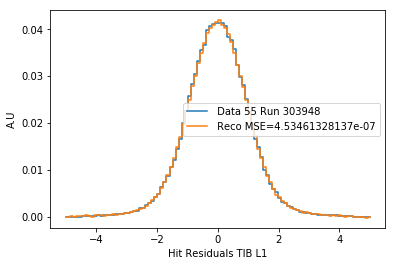

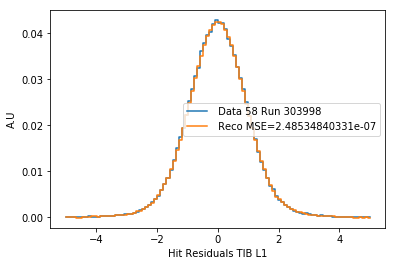

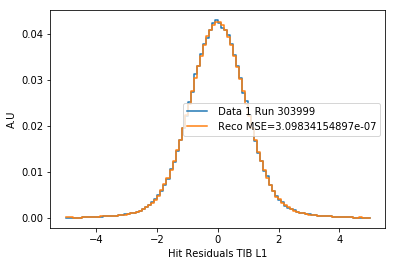

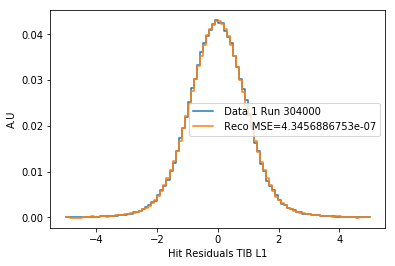

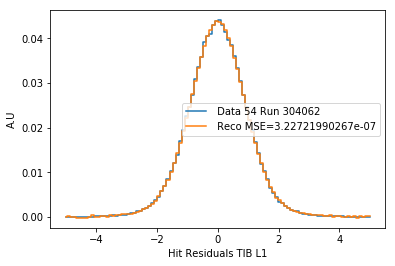

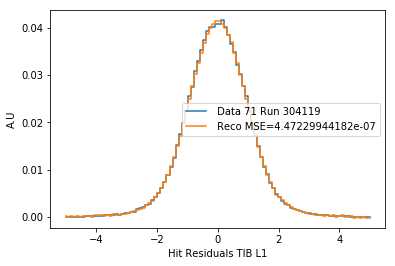

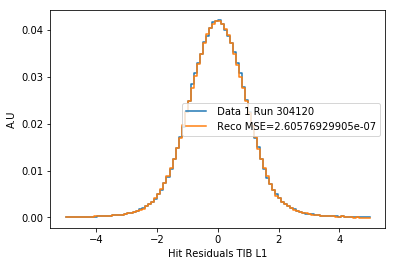

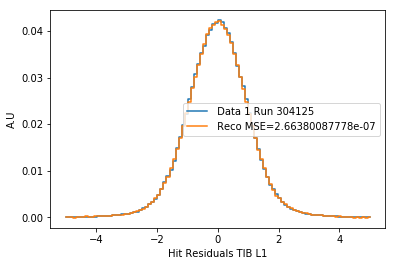

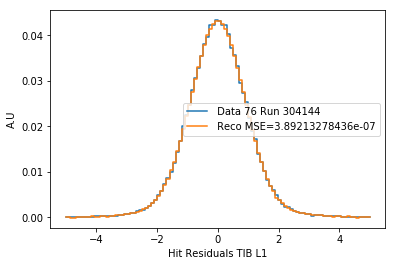

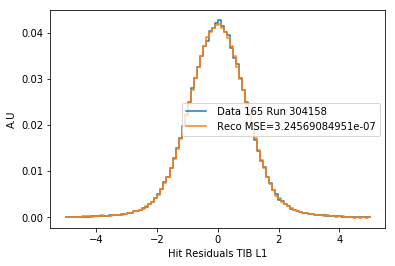

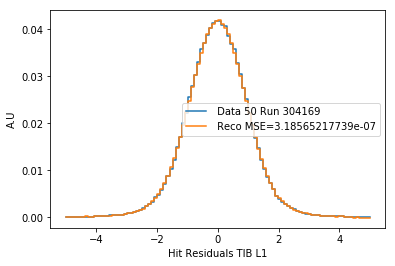

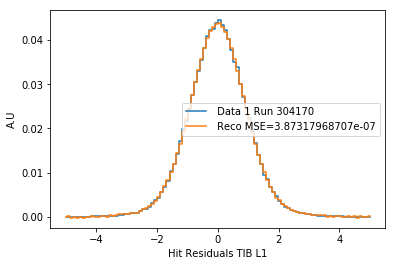

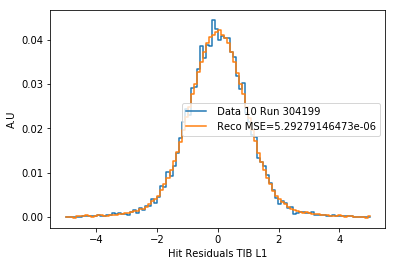

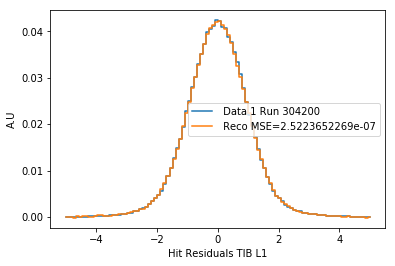

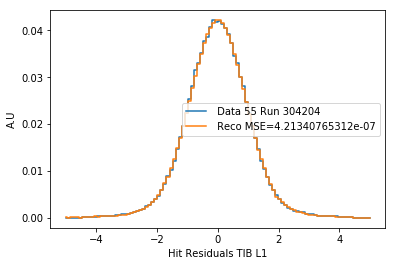

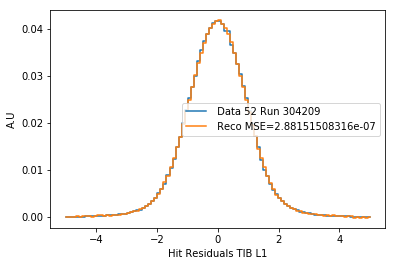

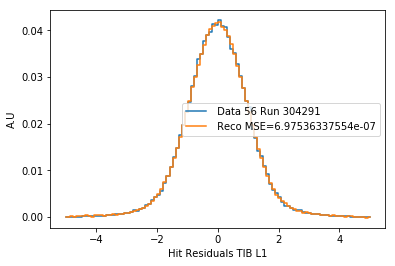

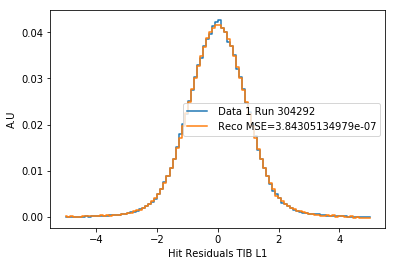

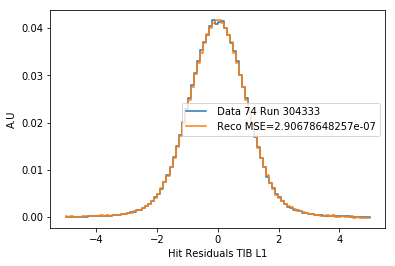

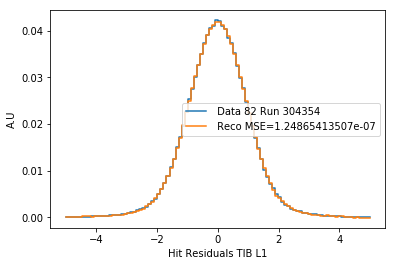

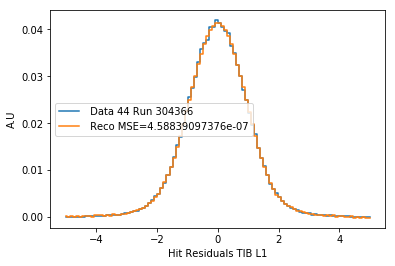

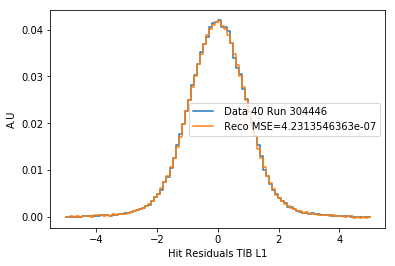

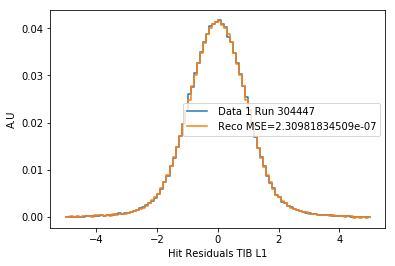

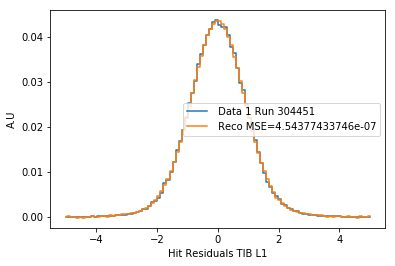

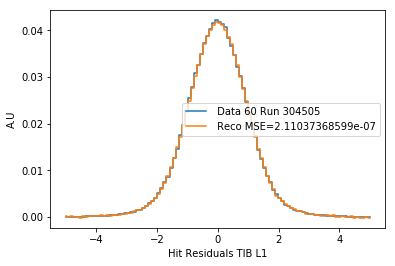

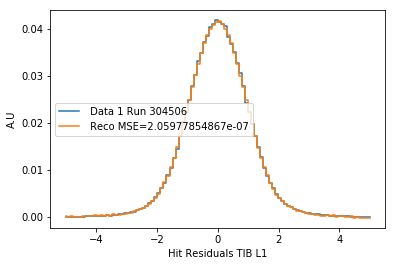

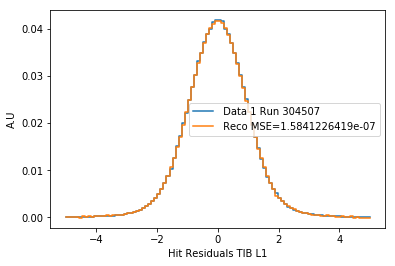

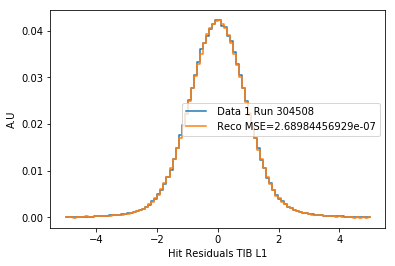

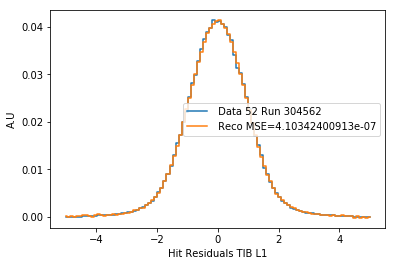

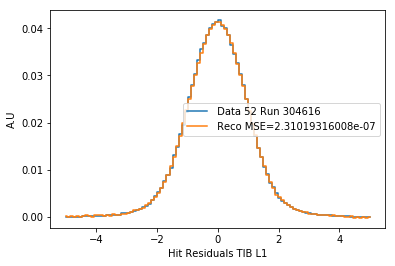

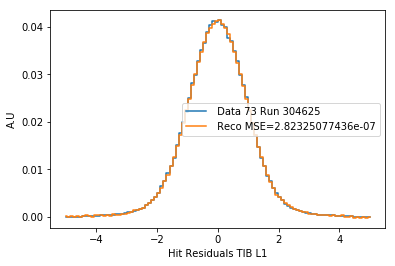

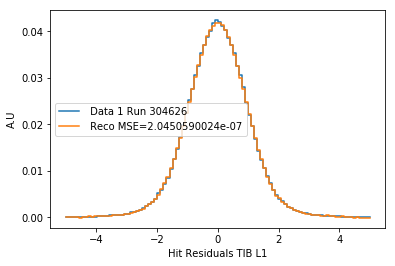

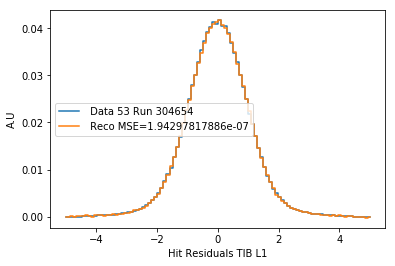

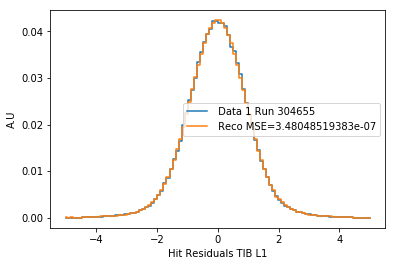

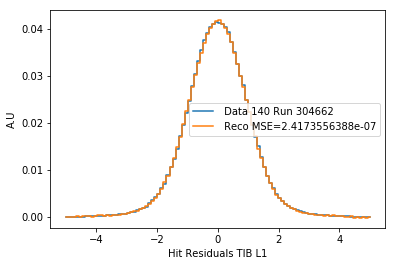

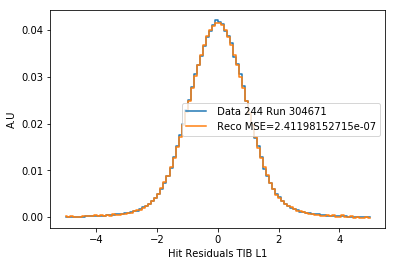

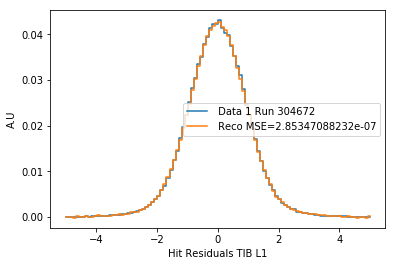

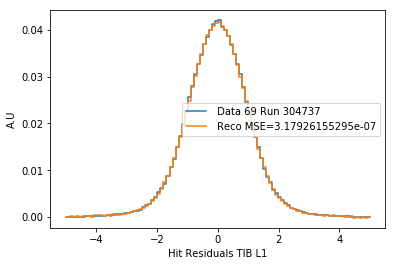

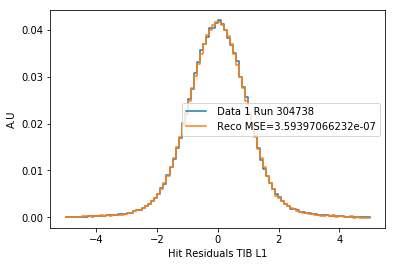

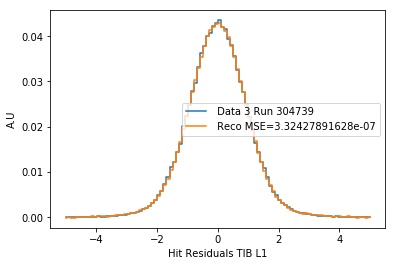

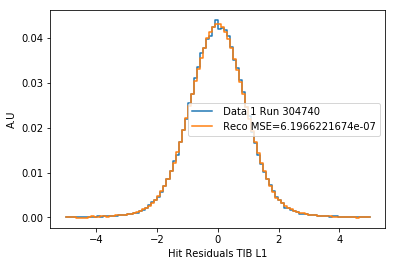

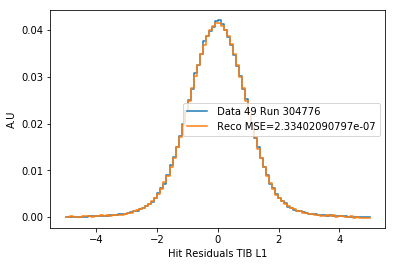

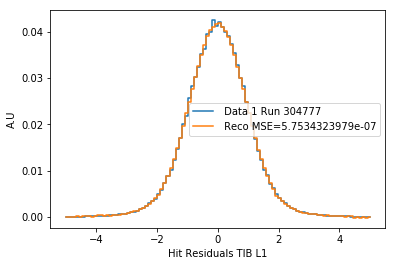

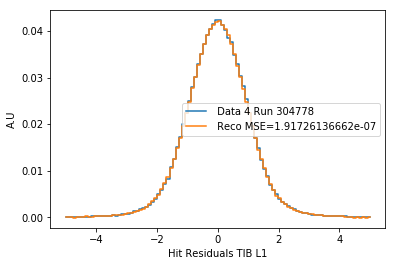

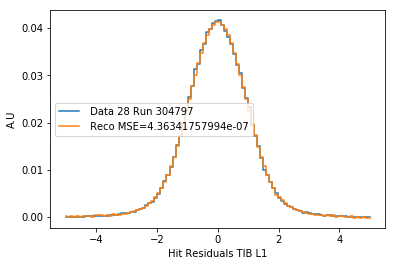

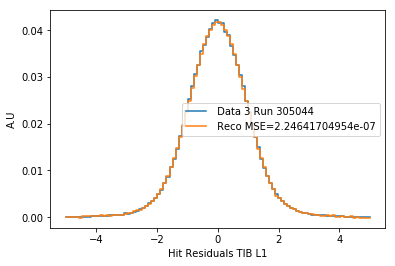

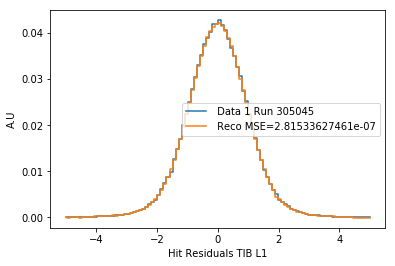

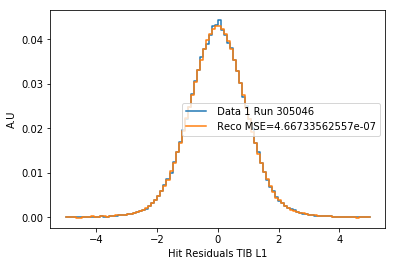

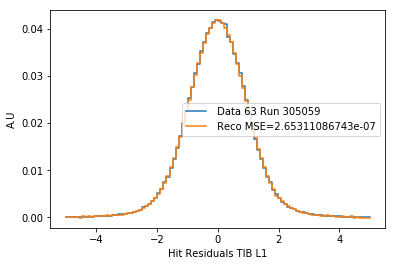

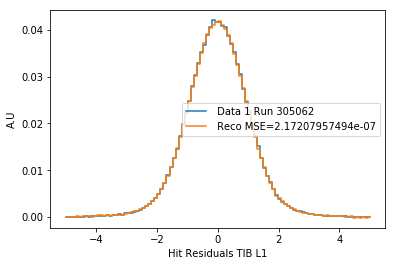

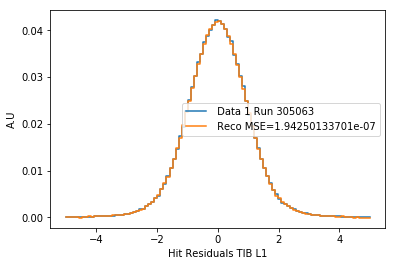

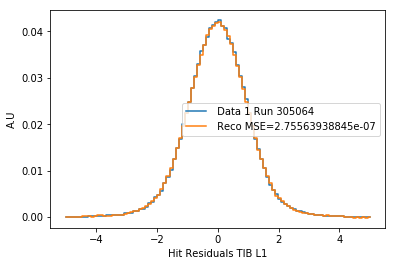

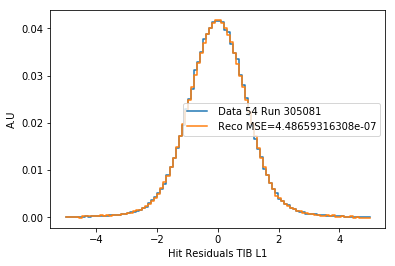

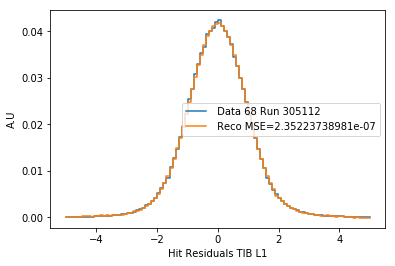

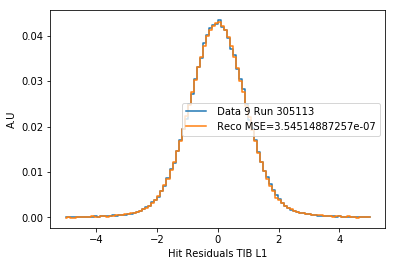

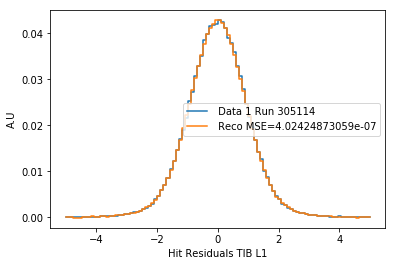

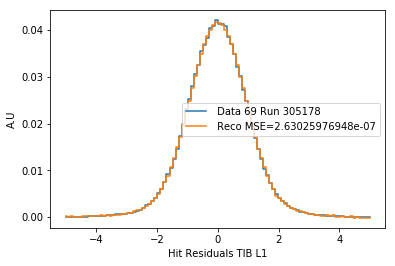

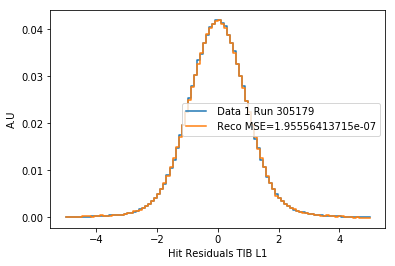

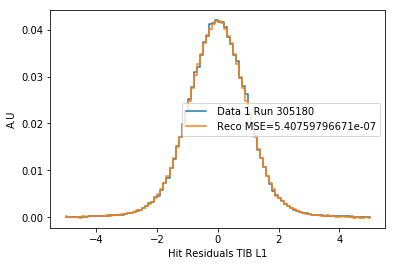

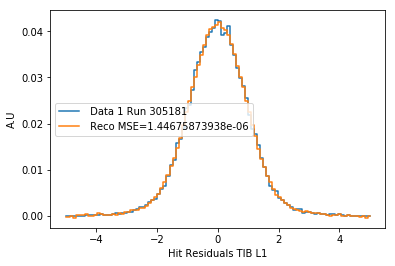

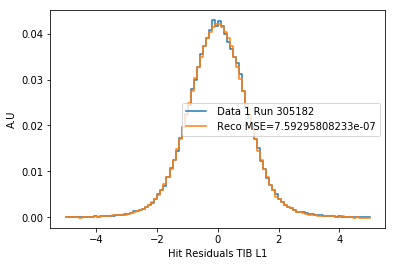

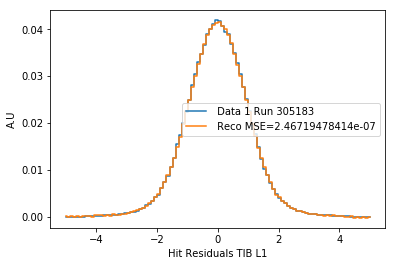

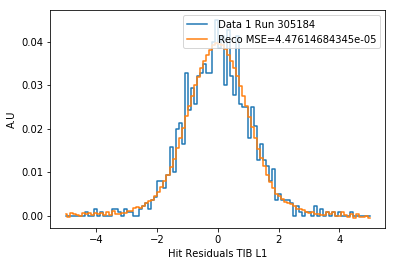

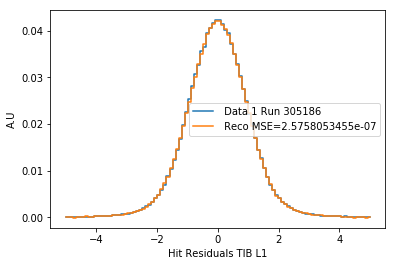

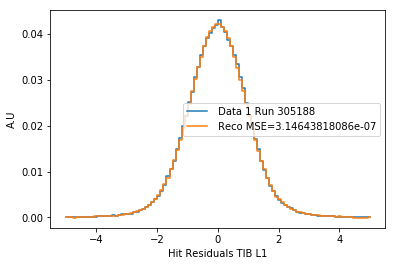

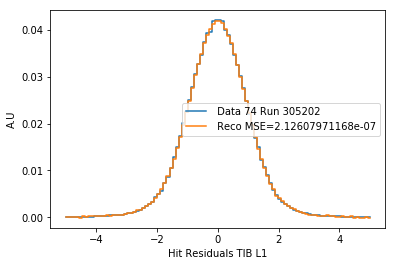

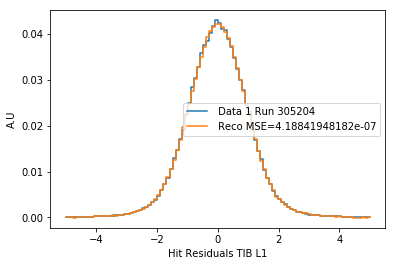

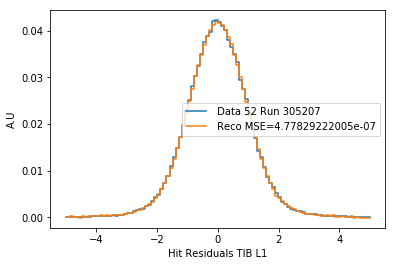

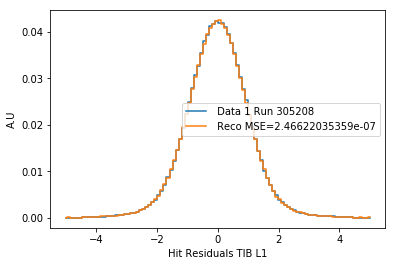

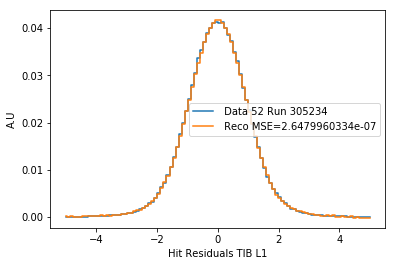

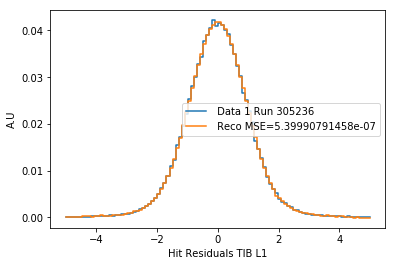

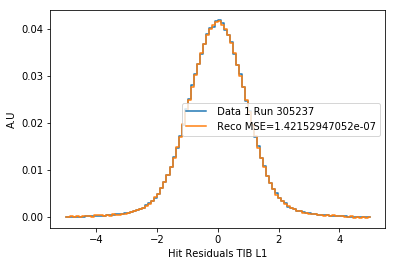

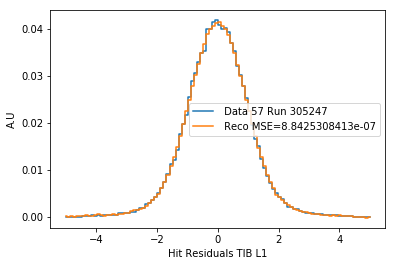

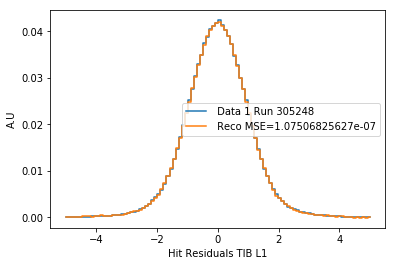

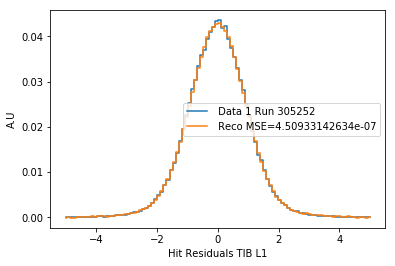

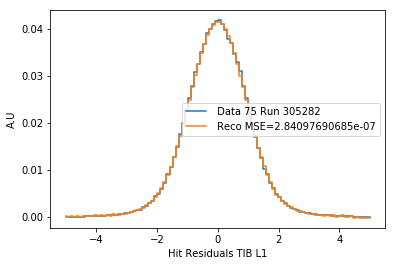

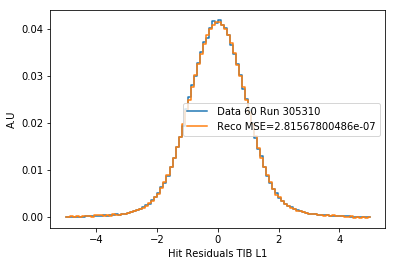

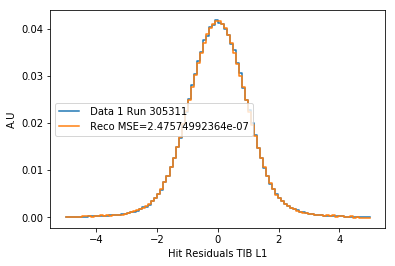

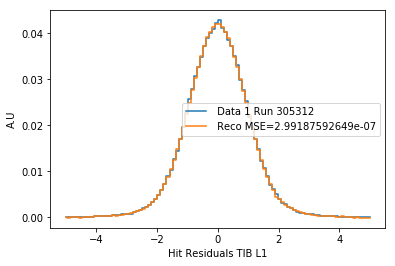

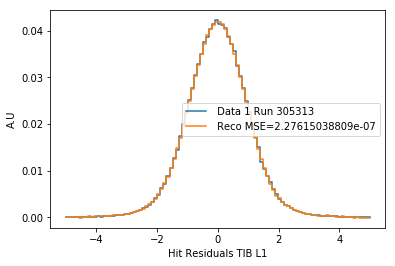

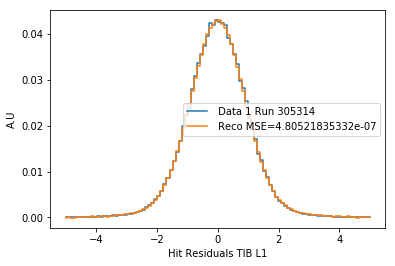

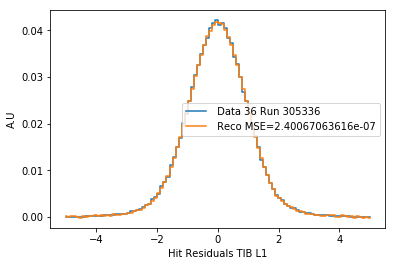

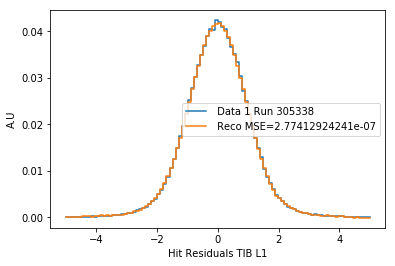

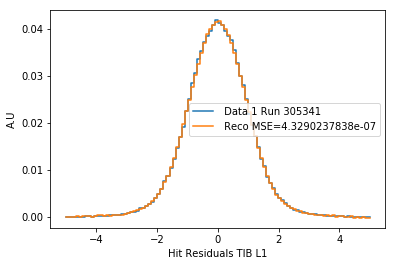

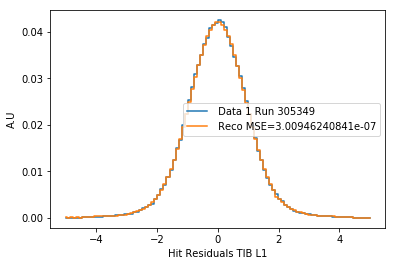

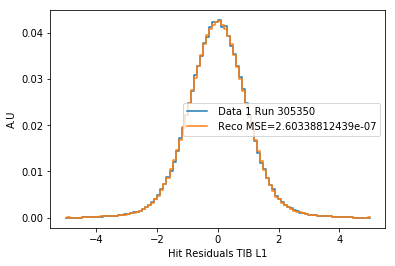

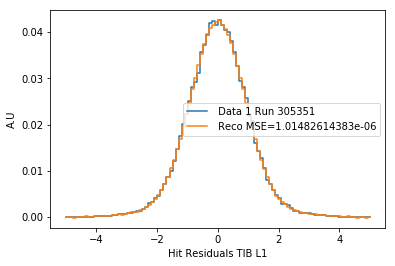

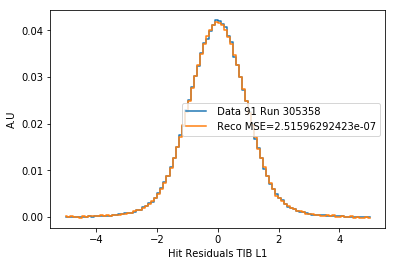

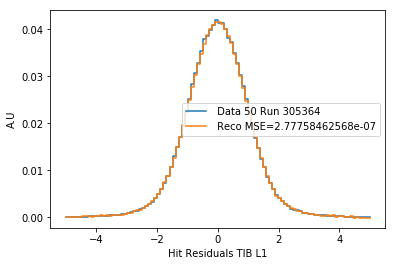

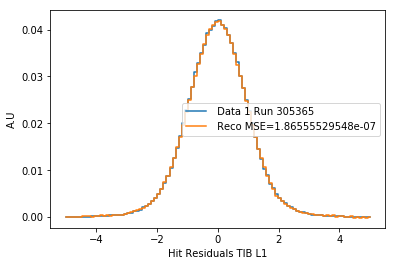

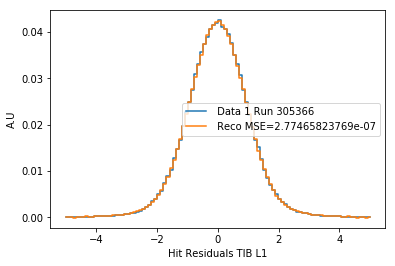

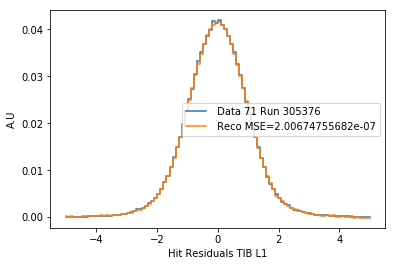

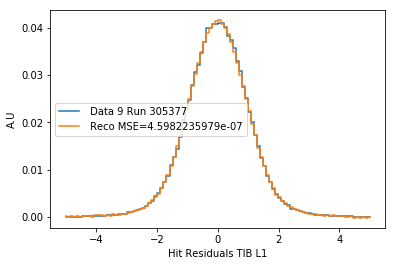

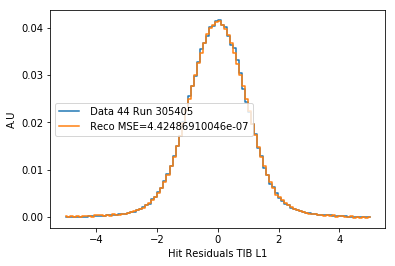

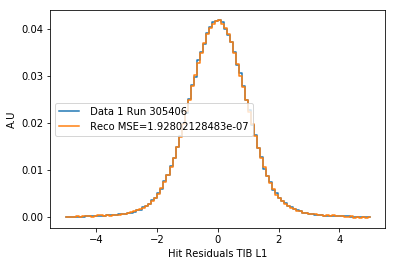

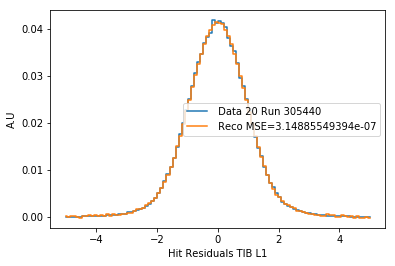

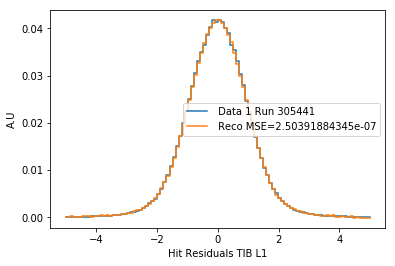

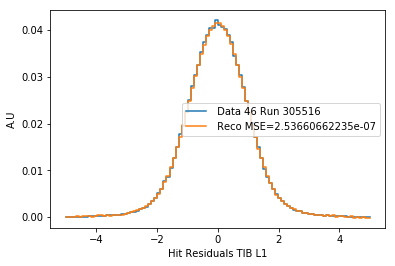

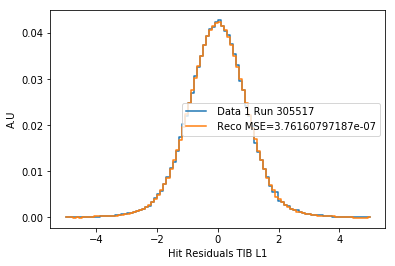

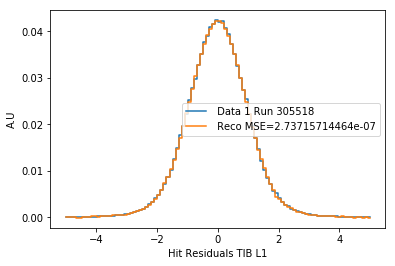

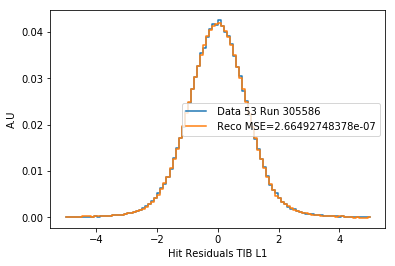

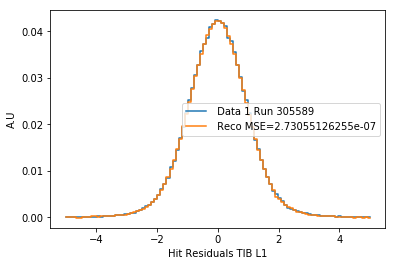

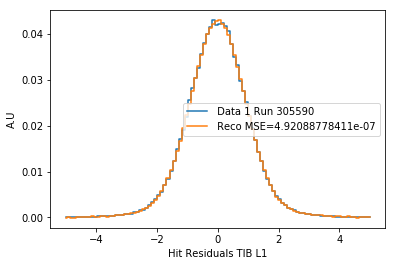

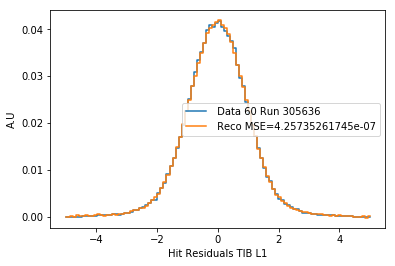

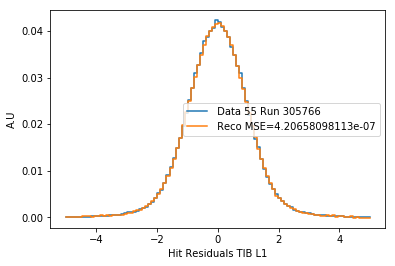

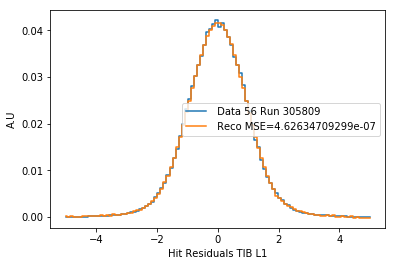

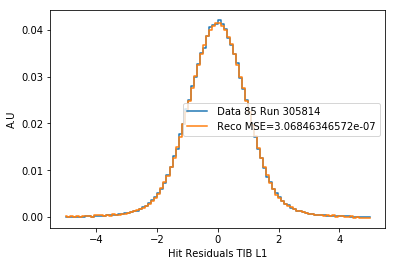

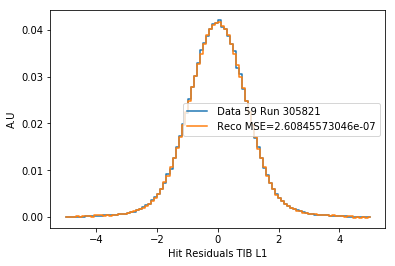

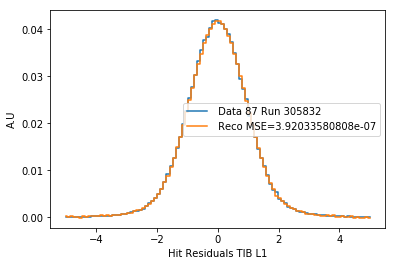

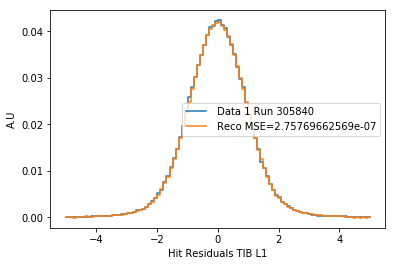

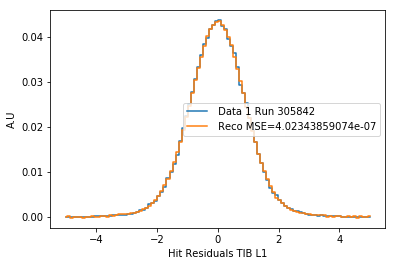

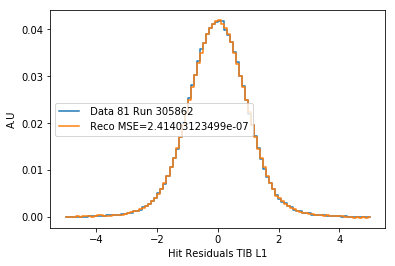

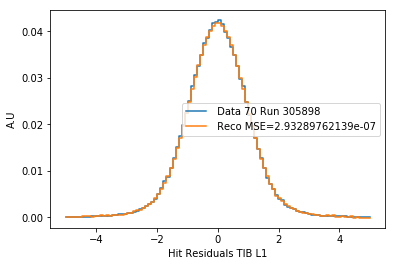

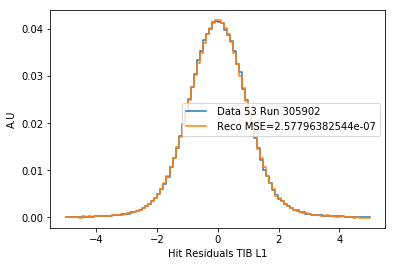

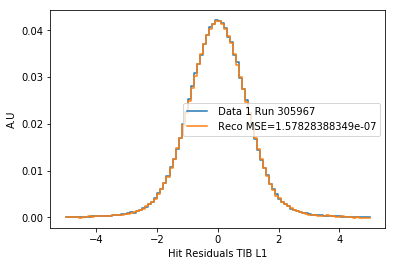

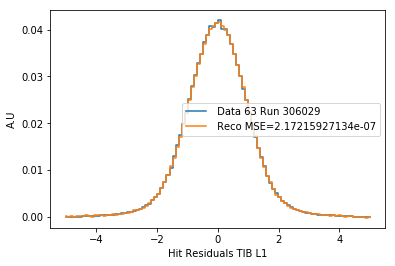

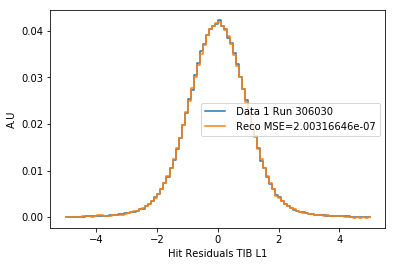

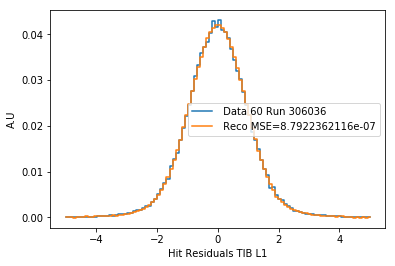

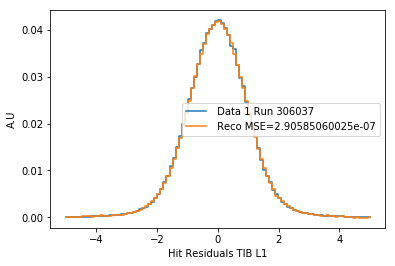

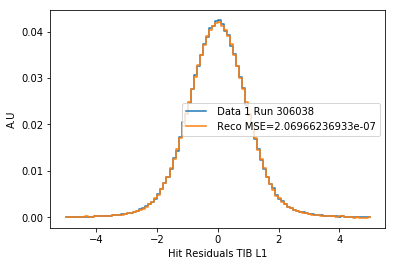

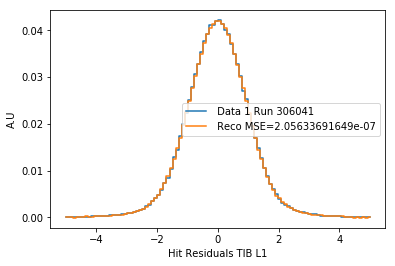

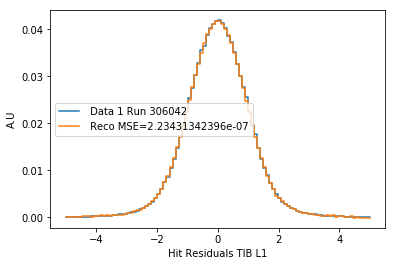

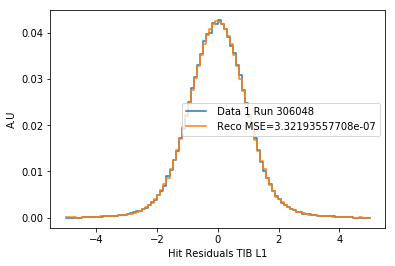

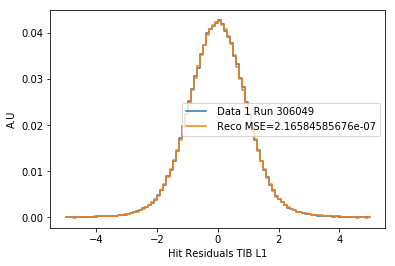

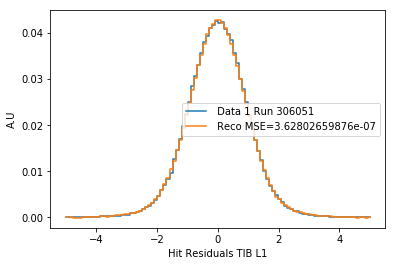

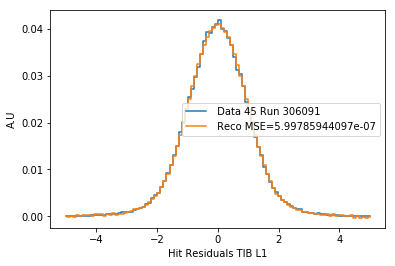

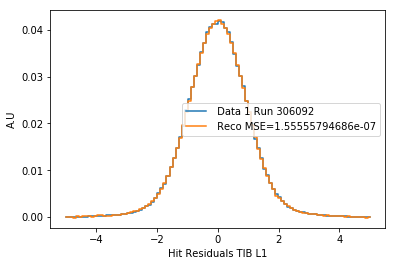

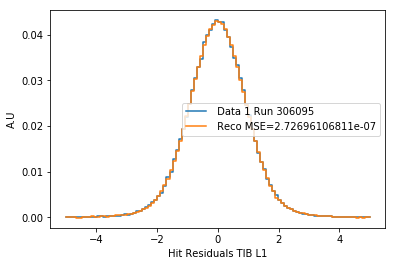

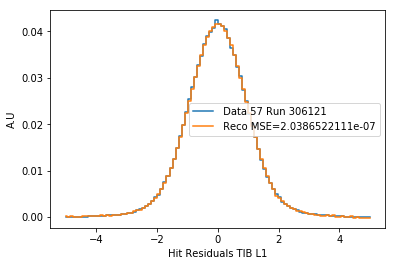

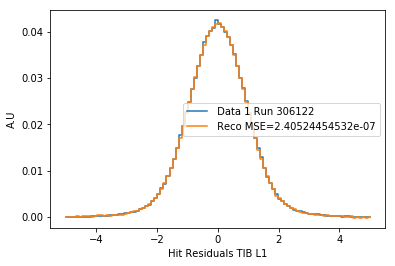

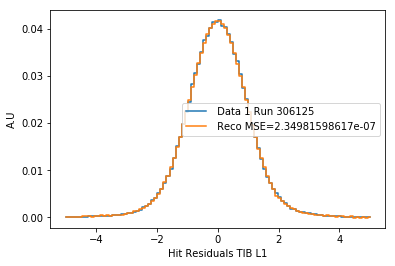

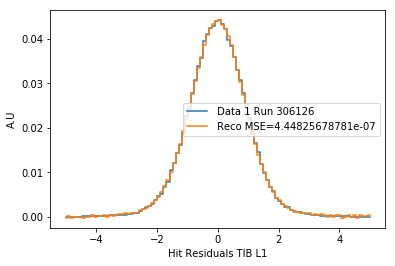

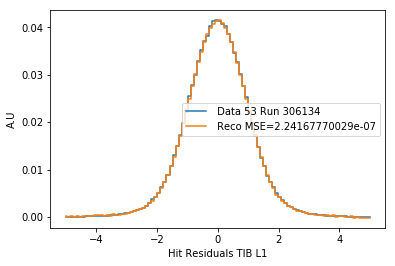

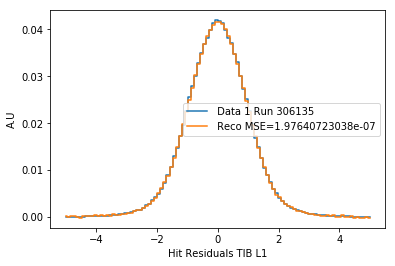

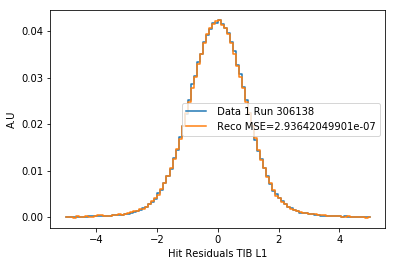

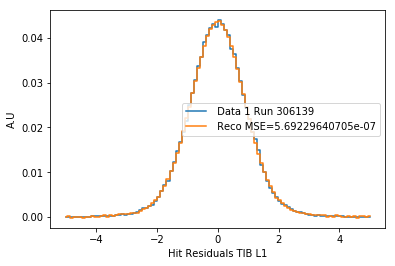

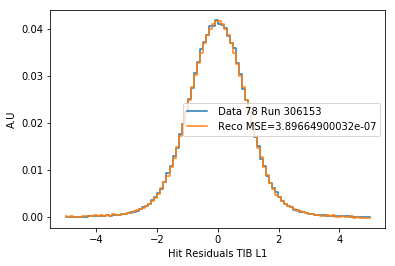

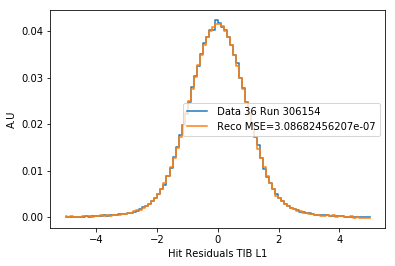

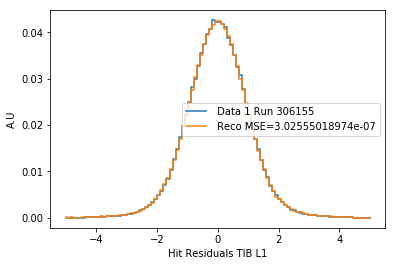

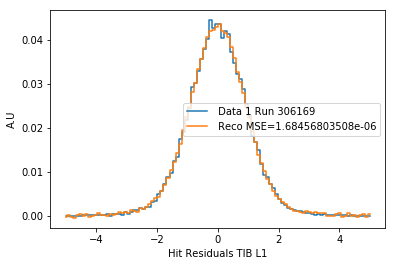

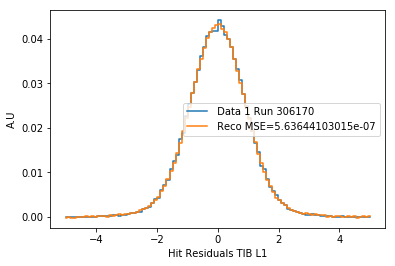

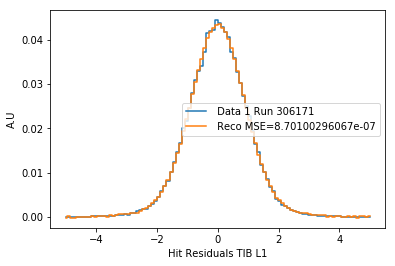

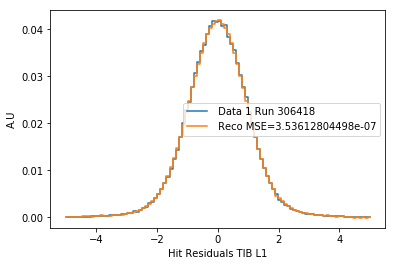

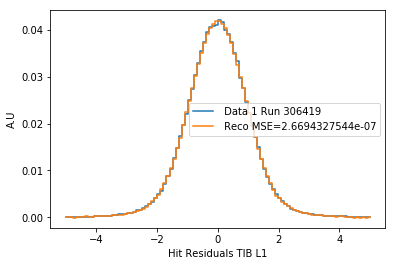

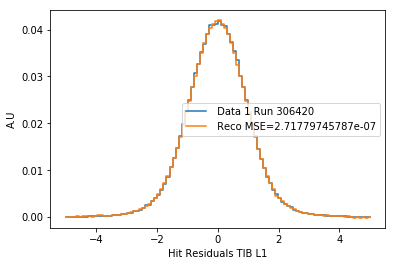

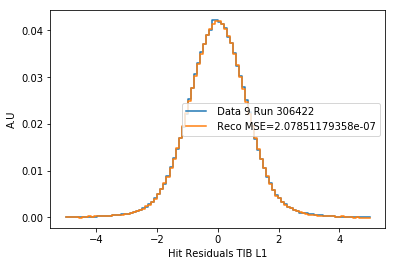

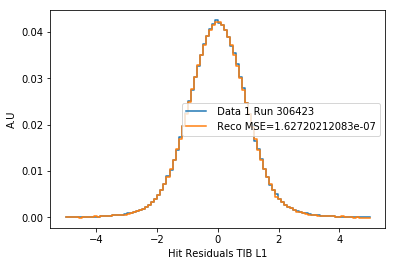

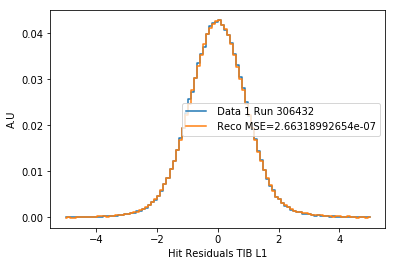

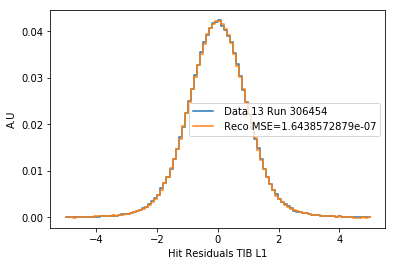

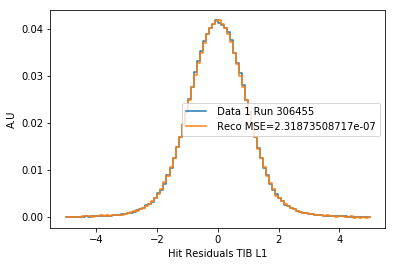

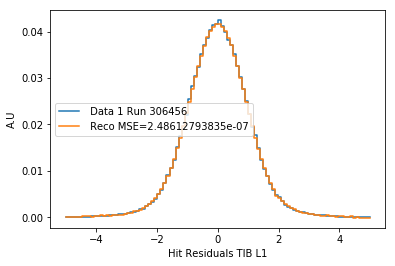

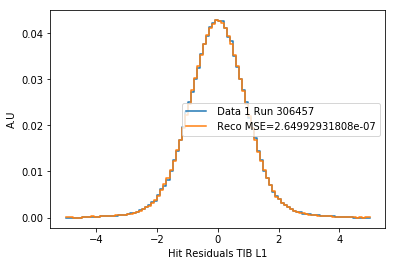

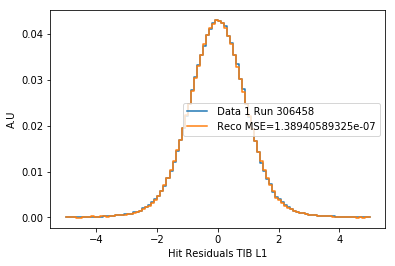

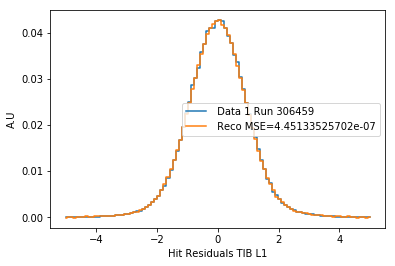

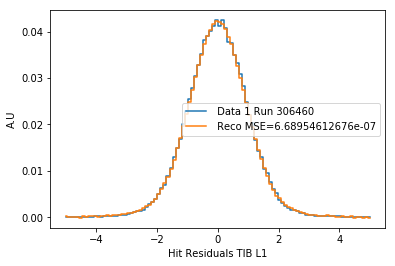

In [20]:
for run in df['fromrun'].unique():
    count=0
    for ls in df['fromlumi'][run]: 
        if df['labels'][run][ls]== False: continue
        if (count >0): continue
        count=count+1
        #CheckPredictions(df[df.train==True], run,ls)
        CheckPredictions(df[df['labels']==True], run,ls)

In [21]:
import pandas as pd
import numpy as np
#X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0)
#no need to normalize, we already have the normalized histogram in the df
print(X_trainA)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
input_size=len(X_train[0])
input_layerA = Input(shape=(input_size, ))

encodedA = Dense(20, activation='sigmoid')(input_layerA)
encoded1A = Dense(10, activation='tanh')(encodedA)
encoded2A = Dense(20, activation='sigmoid')(encoded1A)
decoderA = Dense(input_size, activation='sigmoid')(encoded2A)

autoencoder_Opt = Model(inputs=input_layerA, outputs=decoderA)
autoencoder_Opt.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder_Opt.layers):
             layer.name = 'layer_' + str(i)

autoencoder_Opt.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (InputLayer)         (None, 102)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 20)                2060      
_________________________________________________________________
layer_2 (Dense)              (None, 10)                210       
_________________________________________________________________
layer_3 (Dense)              (None, 20)                220       
_________________________________________________________________
layer_4 (Dense)              (None, 102)               2142      
Total params: 4,632
Trainable params: 4,632
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_Opt = autoencoder_Opt.fit(X_trainA,X_trainA, epochs=300, batch_size=100, shuffle=True, verbose=1,validation_split=0.1)

Train on 182069 samples, validate on 20230 samples
Epoch 1/300
182069/182069 [==============================] - 4s 19us/step - loss: 0.0283 - val_loss: 5.7810e-04
Epoch 2/300
182069/182069 [==============================] - 3s 19us/step - loss: 2.7794e-04 - val_loss: 1.2466e-04
Epoch 3/300
182069/182069 [==============================] - 3s 19us/step - loss: 7.3169e-05 - val_loss: 4.0086e-05
Epoch 4/300
182069/182069 [==============================] - 3s 19us/step - loss: 2.4946e-05 - val_loss: 1.4597e-05
Epoch 5/300
182069/182069 [==============================] - 3s 19us/step - loss: 9.3642e-06 - val_loss: 5.7259e-06
Epoch 6/300
182069/182069 [==============================] - 3s 19us/step - loss: 3.8211e-06 - val_loss: 2.5811e-06
Epoch 7/300
182069/182069 [==============================] - 3s 19us/step - loss: 1.9081e-06 - val_loss: 1.6319e-06
Epoch 8/300
182069/182069 [==============================] - 3s 19us/step - loss: 1.3506e-06 - val_loss: 1.4209e-06
Epoch 9/300
182069/182069

In [1]:
#calculate predictions and mse and add to original DF

originS=np.stack(df['origin'].values, axis=0)
predictionA=autoencoder_Opt.predict(originS)

mseA=K.eval(mseTop10(originS,predictionA))

df['predictions2']=""
df['mse2']=""

df['prediction2']=predictionA.tolist()
df['mse2']=mseA


print(df.head())

NameError: ignored

In [0]:
def CheckAllPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    ahisto2=df_test['prediction2'][run][ls]
    mse=df_test['mse'][run][ls]
    mse2=df_test['mse2'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Raw Reco, mse:" + str(mse))
    plt.step(x, ahisto2, where='mid', label=" Reco, mse:" + str(mse2))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

In [0]:
#compare some old and new predictions

for run in df['fromrun'].unique():
    count=0
    if run <298000: continue
    for ls in df['fromlumi'][run]: 
        if df['train'][run][ls]== True: continue
        if df['mse2'][run][ls]<0.00001: continue
        if df['entries'][run][ls]<3000: continue
        #if (count >2): continue
        count=count+1
        #print(df.entries)[run][ls]
        CheckAllPredictions(df[df.train==False], run,ls)